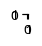

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_roc
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

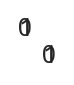

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221028_prime_related_newcore.csv')
ibel = pd.read_csv('../data/mutant/221111_ibel_neoepi_scored_merged.csv')
cp_merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


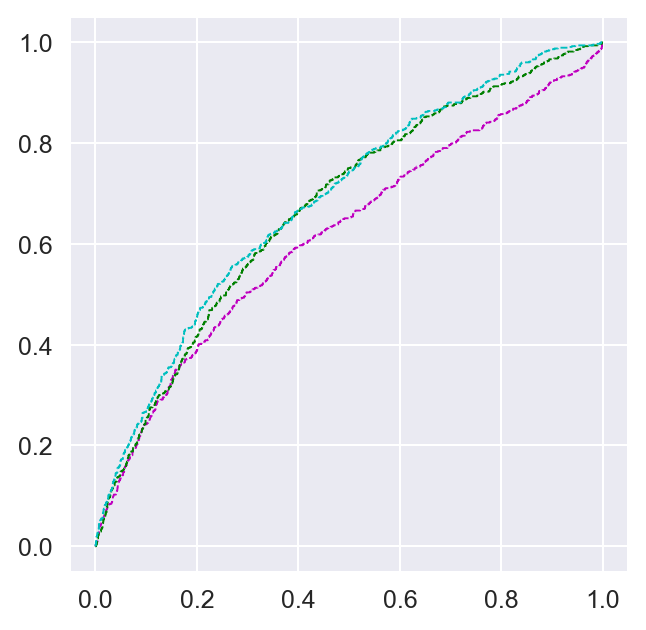

In [5]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [6]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

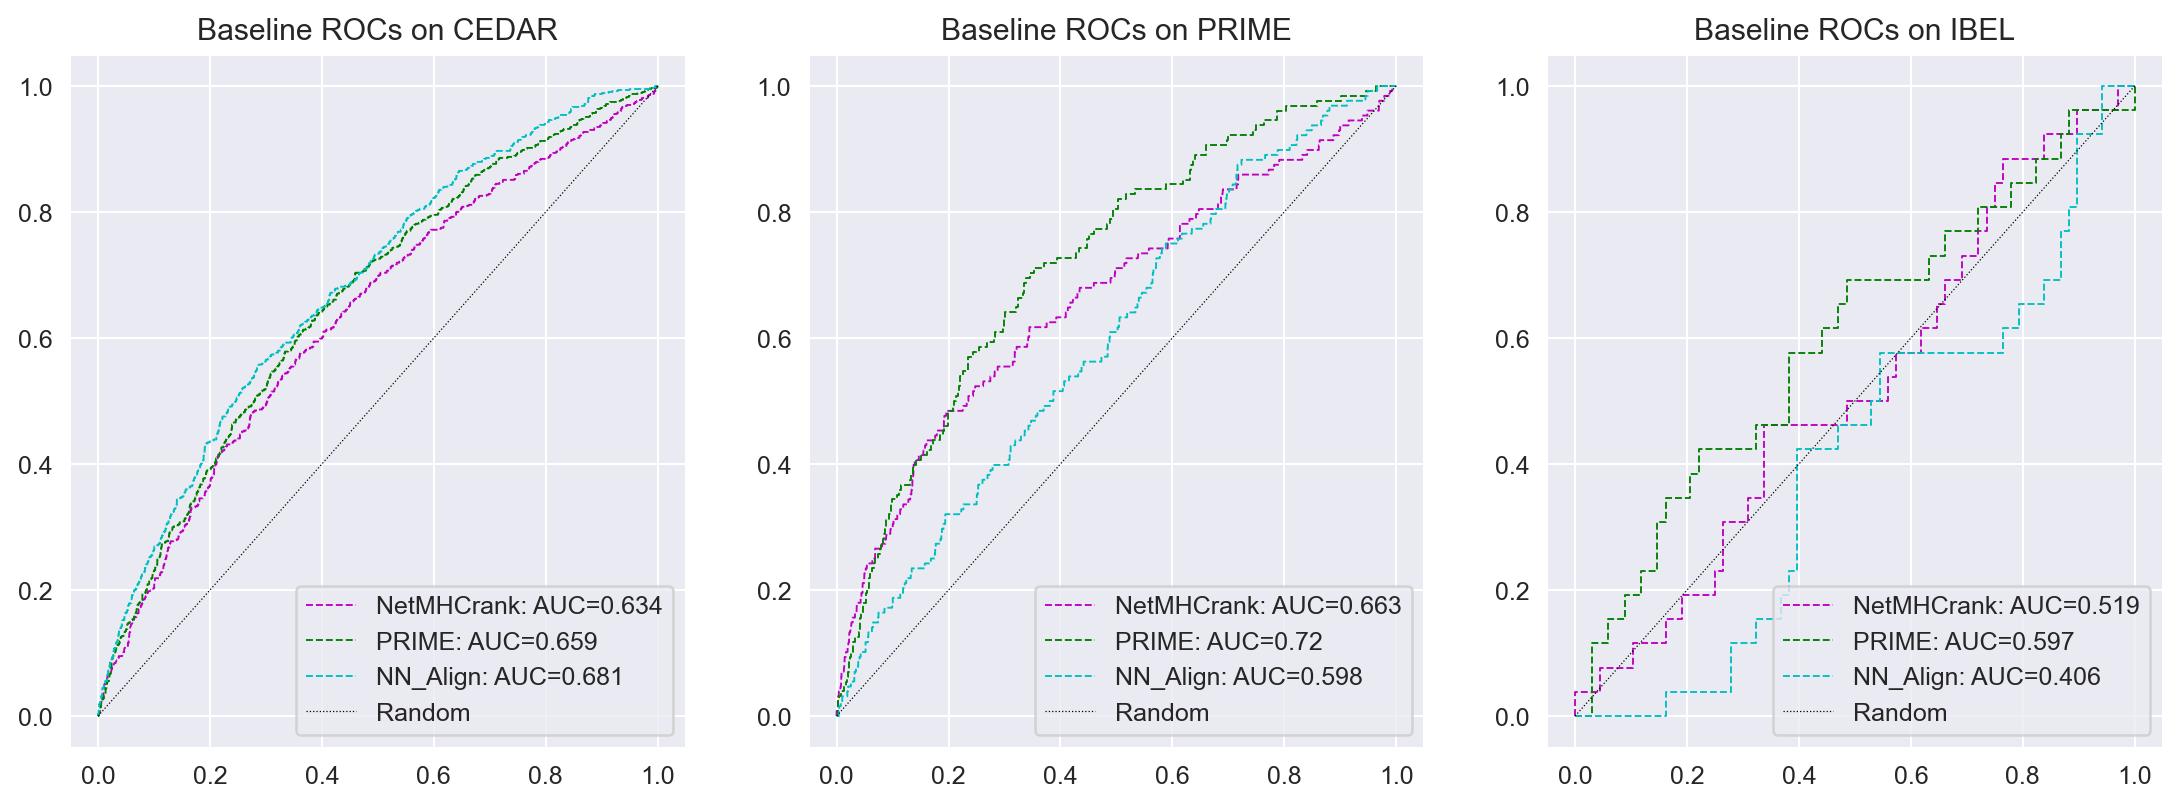

In [7]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

### Check various nnalign baselines

In [ ]:
cedar_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_related.pep_27756/221115_cedar_related.pep_27756.lg6.sorted.pred', sep='\t').sort_values('Peptide')
prime_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_prime_related.pep_35945/221115_prime_related.pep_35945.lg6.sorted.pred', sep='\t').sort_values('Peptide')
ibel_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_ibel_related.pep_23423/221115_ibel_related.pep_23423.lg6.sorted.pred', sep='\t').sort_values('Peptide')
merged_nnalign = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_prime_merged.pep_11365/221115_cedar_prime_merged.pep_11365.lg6.sorted.pred', sep='\t').sort_values('Peptide')

In [91]:
cedar_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_related_LEN8.pep/221115_cedar_related.pep_9059.lg8.sorted.pred', sep='\t').sort_values('Peptide')
prime_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_prime_related_LEN8.pep_16861/221115_prime_related.pep_16861.lg8.sorted.pred', sep='\t').sort_values('Peptide')
ibel_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_ibel_related_LEN8.pep_4773/221115_ibel_related.pep_4773.lg8.sorted.pred', sep='\t').sort_values('Peptide')
merged_nnalign_len8 = pd.read_csv('../../nnalign_cedar/output_baseline/221115_cedar_prime_merged_LEN8.pep_34147/221115_cedar_prime_merged.pep_34147.lg8.sorted.pred', sep='\t').sort_values('Peptide')

Text(0.5, 0.98, 'P1_Rel for different datasets; KDE and histograms')

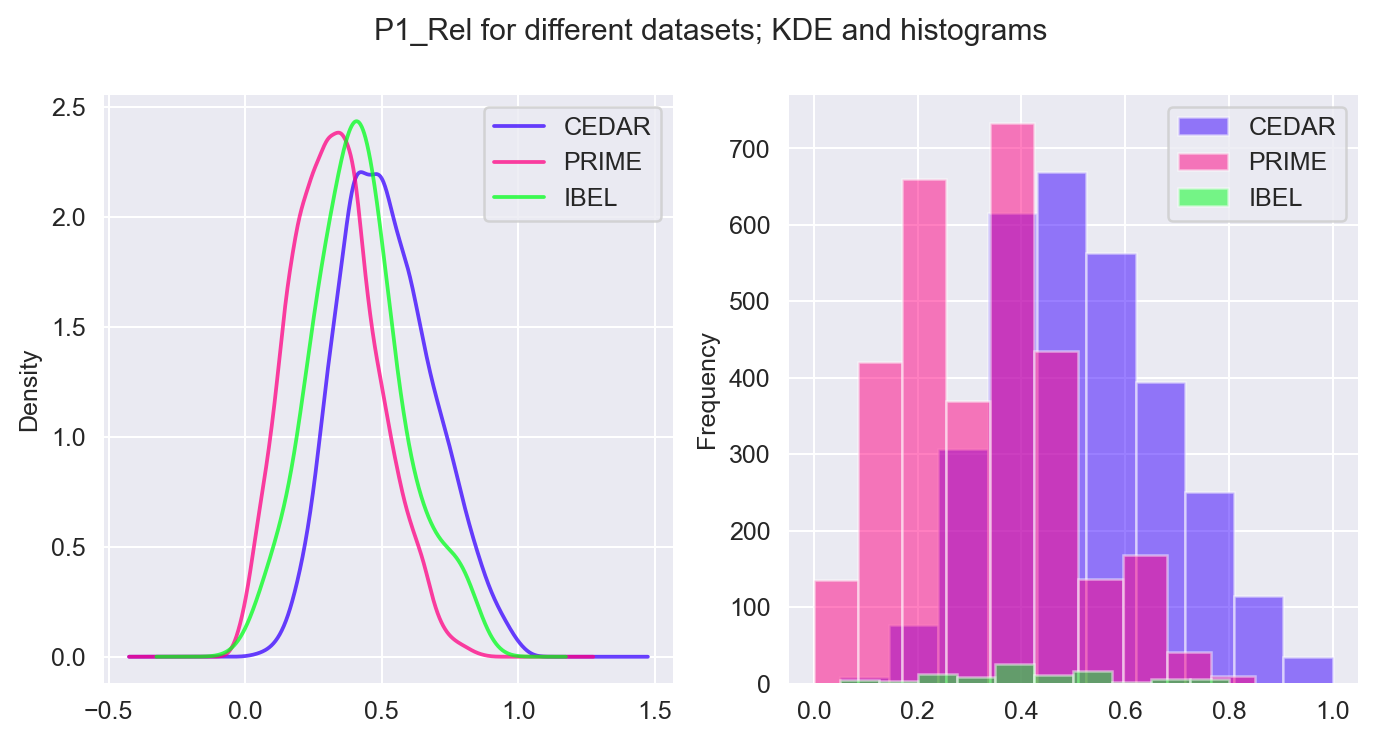

In [84]:
f,a = plt.subplots(1,2, figsize=(9, 4.25))
cedar_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[0], label='CEDAR')
prime_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[1], label='PRIME')
ibel_nnalign.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[-1], label='IBEL')

cedar_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[0], label='CEDAR')
prime_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[1], label='PRIME')
ibel_nnalign.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[-1], label='IBEL')
f.suptitle('P1_Rel for different datasets; KDE and histograms')

Text(0.5, 0.98, 'P1_Rel for different datasets; KDE and histograms')

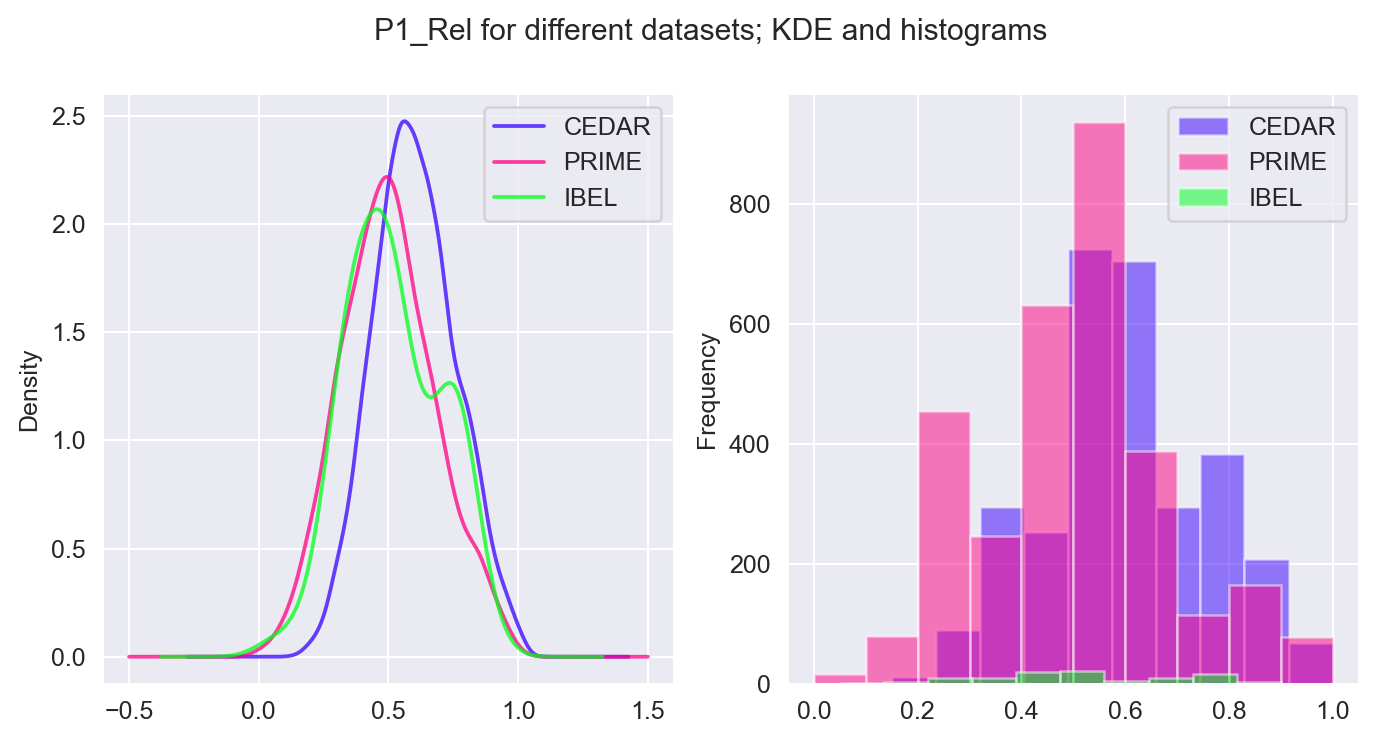

In [92]:
f,a = plt.subplots(1,2, figsize=(9, 4.25))
cedar_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[0], label='CEDAR')
prime_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[1], label='PRIME')
ibel_nnalign_len8.plot(kind='kde', y='P1_Rel', ax=a[0], alpha=0.75, c=HSV[-1], label='IBEL')

cedar_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[0], label='CEDAR')
prime_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[1], label='PRIME')
ibel_nnalign_len8.plot(kind='hist', y='P1_Rel', ax=a[1], alpha=0.5, color=HSV[-1], label='IBEL')
f.suptitle('P1_Rel for different datasets; KDE and histograms')

In [98]:
nnalign_results = {}
print('NNalign scores as baseline')
for name, df in zip(['CEDAR', 'PRIME', 'IBEL', 'MERGED'], [cedar_nnalign,prime_nnalign,ibel_nnalign,merged_nnalign]):
    df['target'] = df.Measure.astype(int)
    nnalign_results[name] = get_roc(df, score='Prediction', target='target')
    print(name, nnalign_results[name]['auc'], nnalign_results[name]['auc01'])

NNalign scores as baseline
CEDAR 0.6775372741415963 0.5539166522962452
PRIME 0.6144527318852734 0.5163612969861756
IBEL 0.40554298642533937 0.47368421052631576
MERGED 0.6702893279732787 0.548123061349165


In [99]:
nnalign_results_len8 = {}
print('NNalign scores as baseline')
for name, df in zip(['CEDAR', 'PRIME', 'IBEL', 'MERGED'], [cedar_nnalign_len8, prime_nnalign_len8, ibel_nnalign_len8, merged_nnalign_len8] ):
    df['target'] = df.Measure.astype(int)
    nnalign_results_len8[name] = get_roc(df, score='Prediction', target='target')
    print(name, nnalign_results[name]['auc'], nnalign_results[name]['auc01'])

NNalign scores as baseline
CEDAR 0.6775372741415963 0.5539166522962452
PRIME 0.6144527318852734 0.5163612969861756
IBEL 0.40554298642533937 0.47368421052631576
MERGED 0.6702893279732787 0.548123061349165


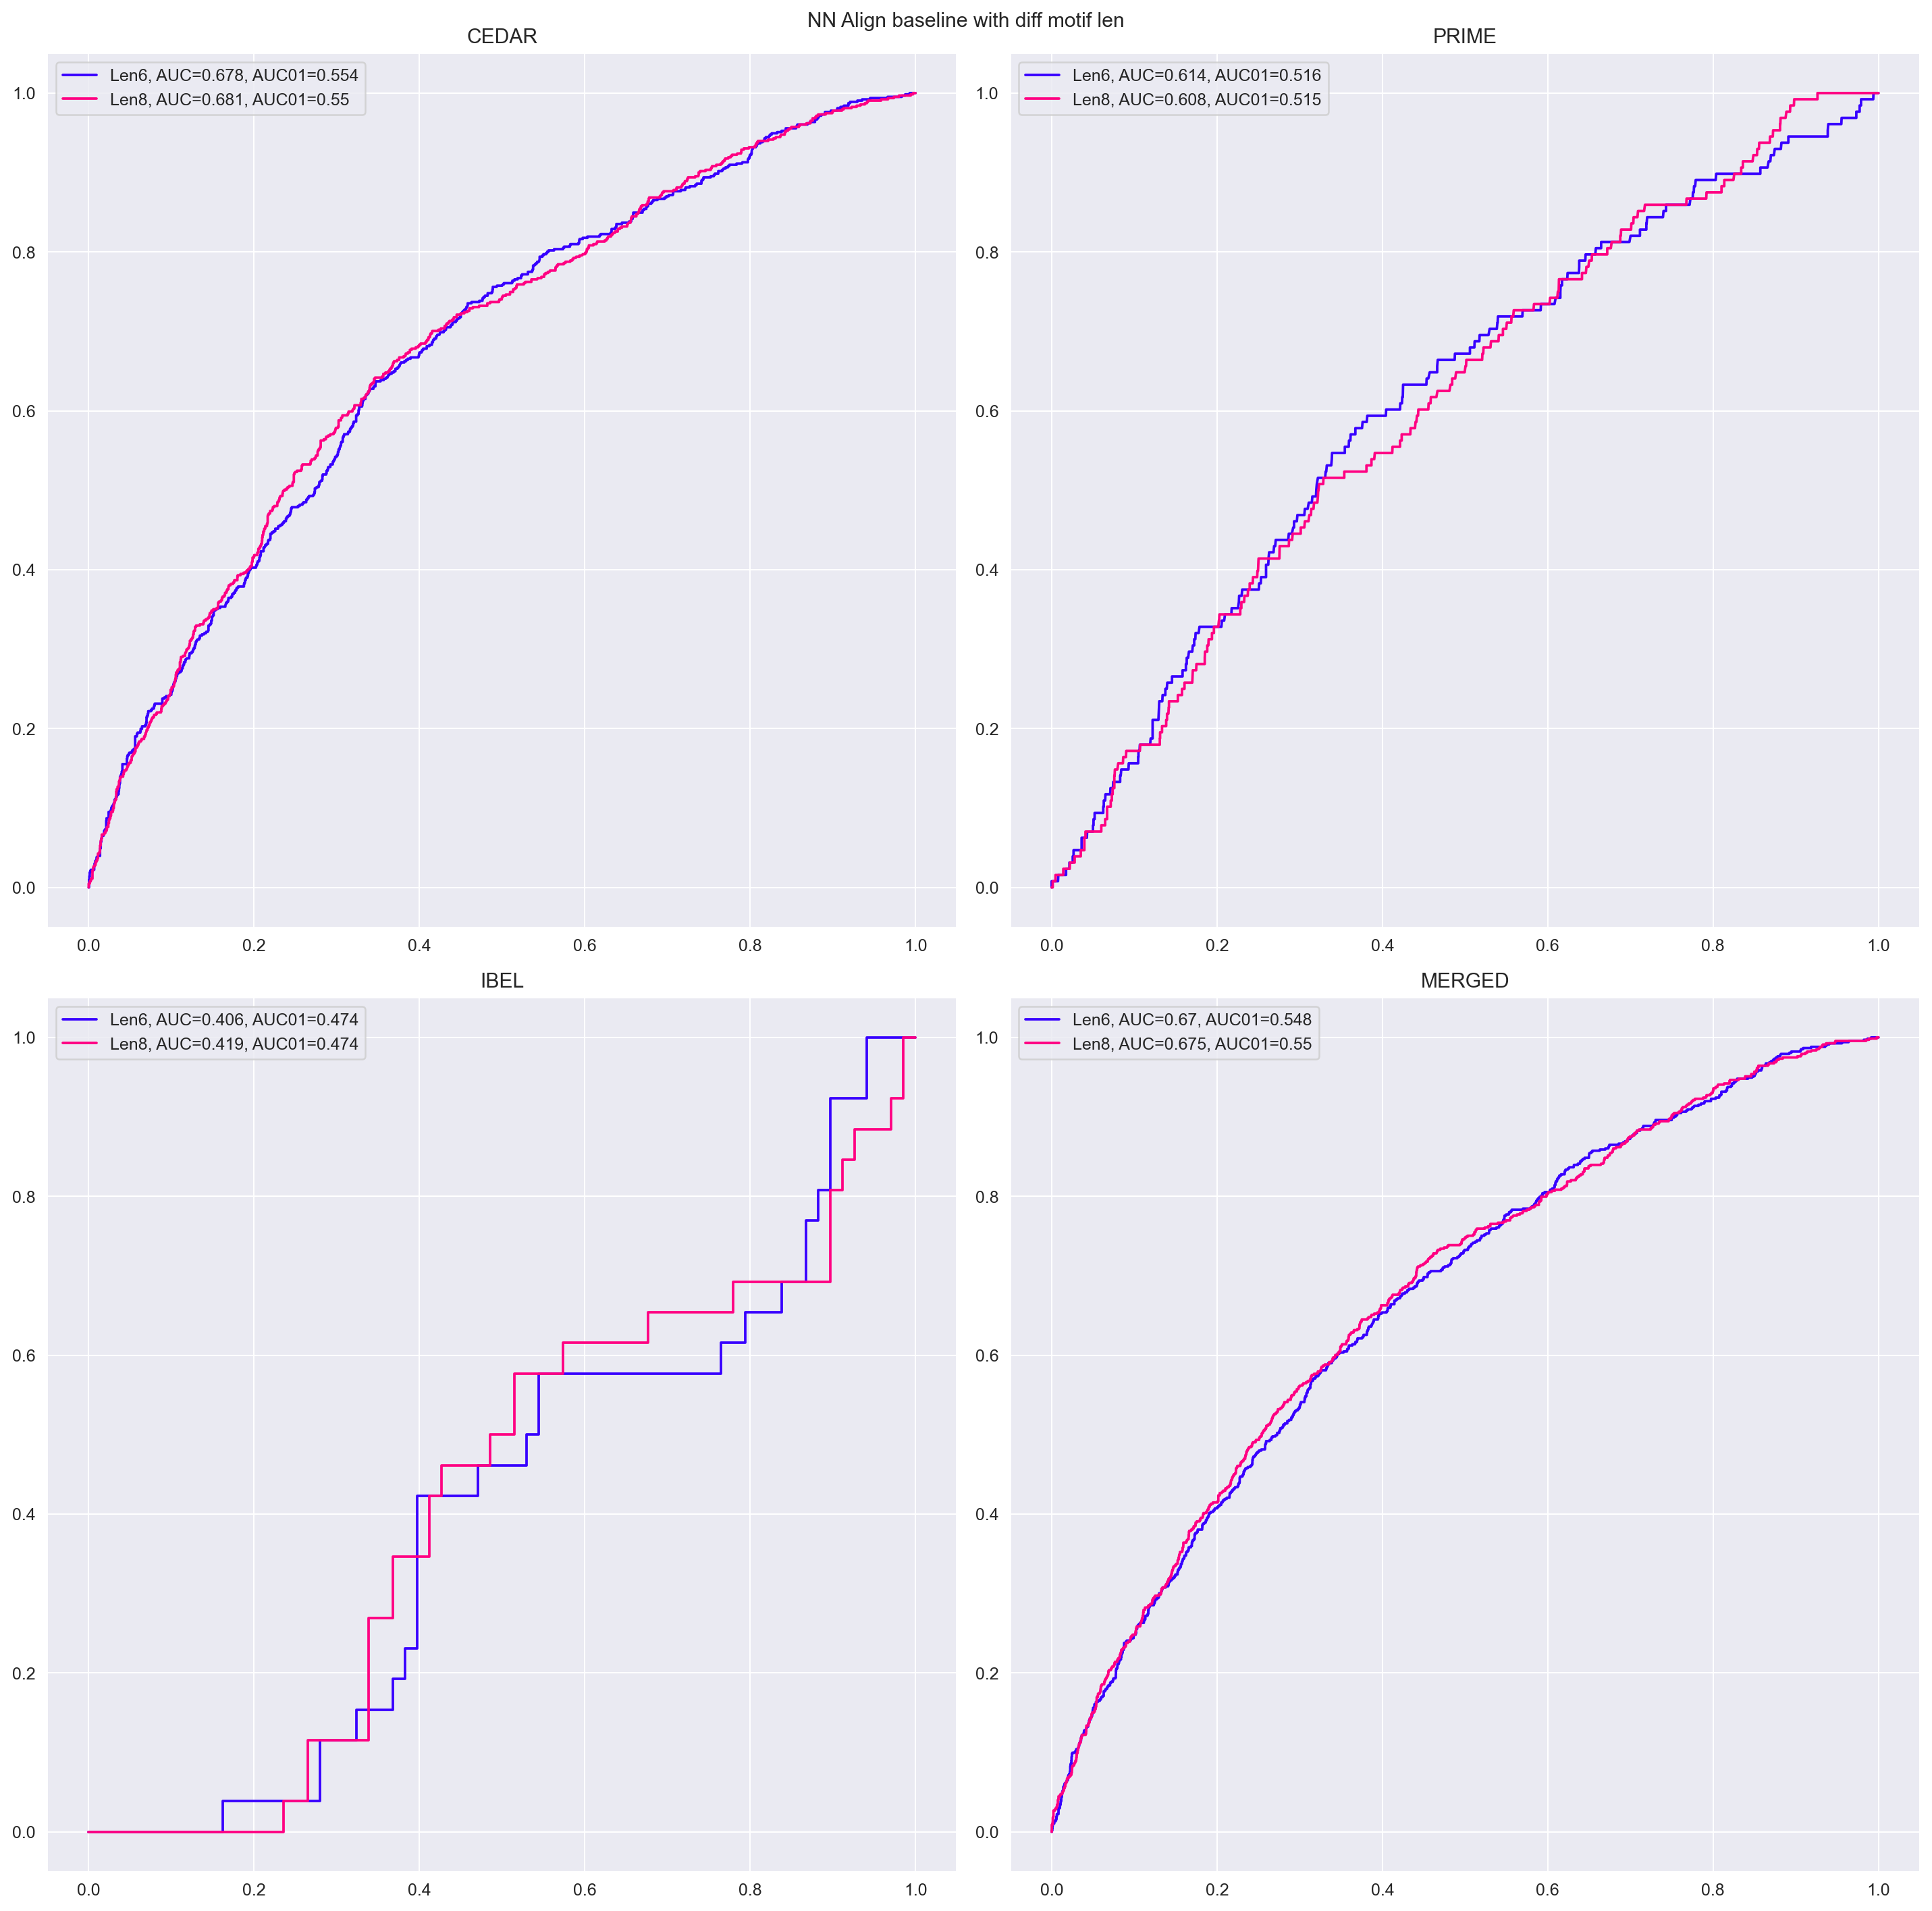

In [103]:
f,a = plt.subplots(2,2,figsize=(16,16))
ax = a.ravel()
for i, k in enumerate(nnalign_results.keys()):
    sns.lineplot(x=nnalign_results[k]['roc'][0], y=nnalign_results[k]['roc'][1], ax=ax[i], estimator=None,
                 label = f"Len6, AUC={round(nnalign_results[k]['auc'],3)}, AUC01={round(nnalign_results[k]['auc01'],3)}")
    sns.lineplot(x=nnalign_results_len8[k]['roc'][0], y=nnalign_results_len8[k]['roc'][1], ax=ax[i], estimator=None,
                 label = f"Len8, AUC={round(nnalign_results_len8[k]['auc'],3)}, AUC01={round(nnalign_results_len8[k]['auc01'],3)}")
    ax[i].set_title(k)
f.suptitle('NN Align baseline with diff motif len')
f.tight_layout()

# Results

In [9]:
df_results_merged = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/bootstrapping/total_df.csv')
df_results = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_without_merged_results.csv')
df_results = pd.concat([df_results, df_results_merged])
del df_results_merged
df_results.to_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_all.csv',index=False)

KeyboardInterrupt: 

In [10]:
df_results = pd.read_csv('../output/221112_new_core_mutscores_mergedtrainset/total_df_all.csv')

In [11]:
def weight_name(weight):
    if weight=='None':
        return weight
    elif 'Inverted' in weight:
        weight = weight.replace('Inverted ', '')
        return f'IC {weight}'
    else:
        return f'(1–IC) {weight}'
df_results['weight'] = df_results['weight'].apply(weight_name)
df_results.weight.unique()

array(['IC Mask', 'IC KL', 'IC Shannon', '(1–IC) Mask', '(1–IC) KL',
       'None', '(1–IC) Shannon'], dtype=object)

## reshape results

In [12]:
score_cols = ['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall']
feat_cols = ['encoding', 'weight','pep_col', 'rank_col', 'key']

df_prime = df_results.query('evalset=="PRIME"').drop(columns=['evalset']).reset_index(drop=True)
df_prime.rename(columns = {k:f'{k}_prime' for k in score_cols}, inplace=True)

df_cedar = df_results.query('evalset=="CEDAR"').drop(columns=['evalset']).reset_index(drop=True)
df_cedar.rename(columns = {k:f'{k}_cedar' for k in score_cols}, inplace=True)

df_ibel = df_results.query('evalset=="IBEL"').drop(columns=['evalset']).reset_index(drop=True)
df_ibel.rename(columns = {k:f'{k}_ibel' for k in score_cols}, inplace=True)

df_merged = df_results.query('evalset=="MERGED"').drop(columns=['evalset']).reset_index(drop=True)
df_merged.rename(columns = {k:f'{k}_merged' for k in score_cols}, inplace=True)

df_reshape = df_cedar.merge(df_prime.drop(columns = feat_cols), left_index=True, right_index=True)\
                     .merge(df_ibel.drop(columns = feat_cols), left_index=True, right_index=True)\
                     .merge(df_merged.drop(columns= feat_cols), left_index=True, right_index=True)

del df_prime
del df_cedar
del df_ibel
del df_merged

## gb_agg checks

In [14]:
# Only keep models that use EL rank mut as rank 
gb_agg = df_results.query('rank_col=="EL_rank_mut"').groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset']).agg(max_AUC=('auc', 'max'),
                                                                                                 mean_AUC=('auc', 'mean'),
                                                                                                 med_AUC=('auc', 'median'),
                                                                                                 std_AUC=('auc', 'std'), 
                                                                                                 max_PRAUC=('prauc', 'max'),
                                                                                                 mean_PRAUC=('prauc', 'mean'),
                                                                                                 med_PRAUC=('prauc', 'median'),
                                                                                                 std_PRAUC=('prauc', 'std')).reset_index('evalset')

gb_reshape = df_reshape.groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key']).agg(max_AUC_cedar=('auc_cedar', 'max'),
                                                                                          mean_AUC_cedar=('auc_cedar', 'mean'),
                                                                                          max_PRAUC_cedar=('prauc_cedar', 'max'),
                                                                                          mean_PRAUC_cedar=('prauc_cedar', 'mean'),
                                                                                          max_AUC_prime=('auc_prime', 'max'),
                                                                                          mean_AUC_prime=('auc_prime', 'mean'),
                                                                                          max_PRAUC_prime=('prauc_prime', 'max'),
                                                                                          mean_PRAUC_prime=('prauc_prime', 'mean'),
                                                                                          max_AUC_ibel=('auc_ibel', 'max'),
                                                                                          mean_AUC_ibel=('auc_ibel', 'mean'),
                                                                                          max_PRAUC_ibel=('prauc_ibel', 'max'),
                                                                                          mean_PRAUC_ibel=('prauc_ibel', 'mean'),
                                                                                          max_AUC_merged=('auc_merged', 'max'),
                                                                                          mean_AUC_merged=('auc_merged', 'mean'),
                                                                                          max_PRAUC_merged=('prauc_merged', 'max'),
                                                                                          mean_PRAUC_merged=('prauc_merged', 'mean'))

## top means etc

In [15]:
top25_mean_cedar = gb_reshape.sort_values('mean_AUC_cedar', ascending=False).head(25)
top25_mean_prime = gb_reshape.sort_values('mean_AUC_prime', ascending=False).head(25)
top25_mean_ibel = gb_reshape.sort_values('mean_AUC_ibel', ascending=False).head(25)
top25_mean_merged = gb_reshape.sort_values('mean_AUC_merged', ascending=False).head(25)


In [21]:
auc_cols = list(filter(lambda x: 'PR' not in x and 'AUC' in x and 'mean' in x, top25_mean_cedar.columns))
auc_cols

['mean_AUC_cedar', 'mean_AUC_prime', 'mean_AUC_ibel', 'mean_AUC_merged']

In [22]:
# MERGED
from IPython.core.display import display, HTML
output = top25_mean_merged[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [132]:
tmp = top25_mean_merged.reset_index('weight').groupby('weight').agg(x=('max_AUC_merged','count'))

In [133]:
tmp

x
weight           
(1–IC) KL       8
(1–IC) Shannon  8
IC Mask         7
None            2

In [143]:
tmp_feats = top25_mean_merged.reset_index('key').groupby('key').agg(x=('max_AUC_merged','count'))
tmp_weight = top25_mean_merged.reset_index('weight').groupby('weight').agg(x=('max_AUC_merged','count'))
feat_merged_appearances={}
idx=list(tmp_feat.index)
vals=tmp_feats.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in feat_merged_appearances.keys():
            feat_merged_appearances[n]+=v
        else:
            feat_merged_appearances[n]=v
print('feats', feat_merged_appearances)

weight_merged_appearances={}
idx=list(tmp_weight.index)
vals=tmp_weight.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in weight_merged_appearances.keys():
            weight_merged_appearances[n]+=v
        else:
            weight_merged_appearances[n]=v
print('weight', weight_merged_appearances)

feats {'blsm_mut_score': 13, 'mutation_score': 25, 'ratio_rank': 11, 'dissimilarity_score': 12}
weight {'(1–IC) KL': 8, '(1–IC) Shannon': 8, 'IC Mask': 7, 'None': 2}


In [24]:
from IPython.core.display import display, HTML
output = top25_mean_cedar[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [142]:
tmp_feats = top25_mean_cedar.reset_index('key').groupby('key').agg(x=('max_AUC_cedar','count'))
tmp_weight = top25_mean_cedar.reset_index('weight').groupby('weight').agg(x=('max_AUC_cedar','count'))
feat_cedar_appearances={}
idx=list(tmp_feat.index)
vals=tmp_feats.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in feat_cedar_appearances.keys():
            feat_cedar_appearances[n]+=v
        else:
            feat_cedar_appearances[n]=v
print('feats', feat_cedar_appearances)

weight_cedar_appearances={}
idx=list(tmp_weight.index)
vals=tmp_weight.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in weight_cedar_appearances.keys():
            weight_cedar_appearances[n]+=v
        else:
            weight_cedar_appearances[n]=v
print('weight', weight_cedar_appearances)

feats {'blsm_mut_score': 15, 'mutation_score': 22, 'ratio_rank': 7, 'dissimilarity_score': 7}
weight {'IC KL': 11, 'IC Shannon': 14}


### PRIME

In [26]:
from IPython.core.display import display, HTML
output = top25_mean_prime[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [141]:
tmp_feats = top25_mean_prime.reset_index('key').groupby('key').agg(x=('max_AUC_prime','count'))
tmp_weight = top25_mean_prime.reset_index('weight').groupby('weight').agg(x=('max_AUC_prime','count'))
feat_prime_appearances={}
idx=list(tmp_feat.index)
vals=tmp_feats.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in feat_prime_appearances.keys():
            feat_prime_appearances[n]+=v
        else:
            feat_prime_appearances[n]=v
print('feats', feat_prime_appearances)

weight_prime_appearances={}
idx=list(tmp_weight.index)
vals=tmp_weight.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in weight_prime_appearances.keys():
            weight_prime_appearances[n]+=v
        else:
            weight_prime_appearances[n]=v
print('weight', weight_prime_appearances)

feats {'blsm_mut_score': 9, 'mutation_score': 19, 'ratio_rank': 12, 'dissimilarity_score': 9}
weight {'(1–IC) KL': 1, '(1–IC) Mask': 23, '(1–IC) Shannon': 1}


### IBEL

In [28]:
from IPython.core.display import display, HTML
output = top25_mean_ibel[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))

In [140]:
tmp_feats = top25_mean_ibel.reset_index('key').groupby('key').agg(x=('max_AUC_ibel','count'))
tmp_weight = top25_mean_ibel.reset_index('weight').groupby('weight').agg(x=('max_AUC_ibel','count'))
feat_ibel_appearances={}
idx=list(tmp_feat.index)
vals=tmp_feats.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in feat_ibel_appearances.keys():
            feat_ibel_appearances[n]+=v
        else:
            feat_ibel_appearances[n]=v
print('feats', feat_ibel_appearances)

weight_ibel_appearances={}
idx=list(tmp_weight.index)
vals=tmp_weight.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in weight_ibel_appearances.keys():
            weight_ibel_appearances[n]+=v
        else:
            weight_ibel_appearances[n]=v
print('weight', weight_ibel_appearances)

feats {'blsm_mut_score': 17, 'mutation_score': 25, 'ratio_rank': 11, 'dissimilarity_score': 16}
weight {'(1–IC) KL': 8, '(1–IC) Shannon': 11, 'IC KL': 2, 'IC Mask': 2, 'None': 2}


In [145]:
print('cedarfeat', feat_cedar_appearances)
print('primefeat', feat_prime_appearances)
print('ibel_feat', feat_ibel_appearances)
print('merged feat', feat_merged_appearances)
print('\n')
print('cedar weight', weight_cedar_appearances)
print('prime weight', weight_prime_appearances)
print('ibel_ weight', weight_ibel_appearances)
print('merged weight', weight_merged_appearances)


cedarfeat {'blsm_mut_score': 15, 'mutation_score': 22, 'ratio_rank': 7, 'dissimilarity_score': 7}
primefeat {'blsm_mut_score': 9, 'mutation_score': 19, 'ratio_rank': 12, 'dissimilarity_score': 9}
ibel_feat {'blsm_mut_score': 17, 'mutation_score': 25, 'ratio_rank': 11, 'dissimilarity_score': 16}
merged feat {'blsm_mut_score': 13, 'mutation_score': 25, 'ratio_rank': 11, 'dissimilarity_score': 12}


cedar weight {'IC KL': 11, 'IC Shannon': 14}
prime weight {'(1–IC) KL': 1, '(1–IC) Mask': 23, '(1–IC) Shannon': 1}
ibel_ weight {'(1–IC) KL': 8, '(1–IC) Shannon': 11, 'IC KL': 2, 'IC Mask': 2, 'None': 2}
merged weight {'(1–IC) KL': 8, '(1–IC) Shannon': 8, 'IC Mask': 7, 'None': 2}


## quick pvalue stuff

In [293]:
gb_agg.sort_values('mean_AUC', ascending=False).head(20).reset_index()\
                                        .query('evalset=="CEDAR"')[['encoding', 'weight', 'pep_col', 'rank_col' ,'key']].values

array([['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut', 'aa_props'],
       ['onehot', 'Inverted Shannon', 'icore_mut', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted Shannon', 'Peptide', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted KL', 'icore_mut', 'EL_rank_mut', 'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'trueHLA_EL_rank',
        'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'mutation_score-ratio_rank'],
       ['BL62FREQ', 'Inverted Shannon', 'icore_mut', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted Shannon', 'Peptide', 'trueHLA_EL_rank',
        'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'blsm_mut_score-mutation_score'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'core_blsm_mut_score-ratio_rank'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'blsm_mut_score-ratio_rank'],
       ['onehot', 'Inve

In [180]:
auc_a = df_a.auc.values
auc_b = df_results.query('encoding=="BL62FREQ" and evalset=="CEDAR" and rank_col=="EL_rank_mut" and key=="aa_props" and pep_col=="icore_mut" and weight=="Shannon"').auc.values
a_over_b = [x>y for x,y in zip(auc_a, auc_b)]
pval = 1 - (len((auc_a>auc_b).astype(int).nonzero()[0]) / 10000 )
pval

0.0010999999999999899

In [248]:
df_results.columns

Index(['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall',
       'encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset'],
      dtype='object')

# plots

## ROCs

In [31]:
print('top25_mean_cedar')
display(top25_mean_cedar.head(1)[auc_cols])
print('top25_mean_prime')
display(top25_mean_prime.head(1)[auc_cols])
print('top25_mean_ibel')
display(top25_mean_ibel.head(1)[auc_cols])
print('top25_mean_merged')
display(top25_mean_merged.head(1)[auc_cols])

gb_reshape['mean_CEDAR_PRIME_AUC'] = gb_reshape.apply(lambda x: np.mean([x['mean_AUC_cedar'], x['mean_AUC_prime'], x['mean_AUC_ibel']]), axis=1)
gb_reshape['mean_CEDAR_PRIME_AUC_weighted'] = 0.75*gb_reshape['mean_AUC_cedar']+0.25*gb_reshape['mean_AUC_prime']+0.25*gb_reshape['mean_AUC_ibel']
print('mean')
display(gb_reshape.sort_values('mean_CEDAR_PRIME_AUC',ascending=False).head(1)[auc_cols])
print('weighted')
display(gb_reshape.sort_values('mean_CEDAR_PRIME_AUC_weighted',ascending=False).head(1)[auc_cols])

top25_mean_cedar


mean_AUC_cedar  mean_AUC_prime  \
encoding weight pep_col rank_col    key                                        
onehot   IC KL  Peptide EL_rank_mut aa_props        0.728261        0.687683   

                                              mean_AUC_ibel  mean_AUC_merged  
encoding weight pep_col rank_col    key                                       
onehot   IC KL  Peptide EL_rank_mut aa_props       0.573483         0.723463

top25_mean_prime


mean_AUC_cedar  \
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score        0.700505   

                                                                                  mean_AUC_prime  \
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score        0.727533   

                                                                                  mean_AUC_ibel  \
encoding weight      pep_col rank_col    key                                                      
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score       0.549523   

                                                                                  mean_AUC_merged  
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_mutation_score         0.712286

top25_mean_ibel


mean_AUC_cedar  \
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score        0.696682   

                                                                                                   mean_AUC_prime  \
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score        0.660428   

                                                                                                   mean_AUC_ibel  \
encoding weight         pep_col rank_col        key                                                                
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score       0.678363   

                                                                                                   mean_AUC_merged  
encoding weight         pep_col rank_col        key                                                                 
onehot   (1–IC) Shannon Peptide trueHLA_EL_rank dissimilarity_score-blsm_mut_score-mutation_score         0.813261

top25_mean_merged


mean_AUC_cedar  \
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score        0.714302   

                                                                                                 mean_AUC_prime  \
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score        0.670563   

                                                                                                 mean_AUC_ibel  \
encoding weight         pep_col   rank_col    key                                                                
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score       0.643095   

                                                                                                 mean_AUC_merged  
encoding weight         pep_col   rank_col    key                                                                 
onehot   (1–IC) Shannon icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score-mutation_score         0.826389

mean


mean_AUC_cedar  \
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score        0.707047   

                                                                           mean_AUC_prime  \
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score        0.684864   

                                                                           mean_AUC_ibel  \
encoding weight         pep_col rank_col    key                                            
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score       0.662822   

                                                                           mean_AUC_merged  
encoding weight         pep_col rank_col    key                                             
onehot   (1–IC) Shannon Peptide EL_rank_mut blsm_mut_score-mutation_score         0.819113

weighted


mean_AUC_cedar  \
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score        0.713107   

                                                                             mean_AUC_prime  \
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score        0.680473   

                                                                             mean_AUC_ibel  \
encoding weight         pep_col   rank_col    key                                            
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score       0.652141   

                                                                             mean_AUC_merged  
encoding weight         pep_col   rank_col    key                                             
onehot   (1–IC) Shannon icore_mut EL_rank_mut blsm_mut_score-mutation_score          0.82628

### get and load best cdts

In [33]:
best_cedar_cdt = 'onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props'
best_prime_cdt = 'onehot_Mask_Peptide_EL_rank_mut_dissimilarity_score-core_mutation_score'
best_ibel_cdt = 'onehot_Shannon_Peptide_EL_rank_mut_dissimilarity_score-blsm_mut_score-mutation_score'
best_merged_cdt = 'onehot_Shannon_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score-mutation_score'
best_mean_cdt = 'onehot_Shannon_Peptide_EL_rank_mut_blsm_mut_score-mutation_score'
best_weighted_cdt = 'onehot_Shannon_icore_mut_EL_rank_mut_blsm_mut_score-mutation_score'

In [34]:
dir_ = '../output/221112_new_core_mutscores_mergedtrainset/bootstrapping/'
# Best cedar cdt
best_cedar_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_cedar_cdt}.pkl')
best_cedar_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_cedar_cdt}.pkl')

# best prime cdt
best_prime_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_prime_cdt}.pkl')
best_prime_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_prime_cdt}.pkl')

# Best IBEL cdt
best_ibel_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_ibel_cdt}.pkl')
best_ibel_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_ibel_cdt}.pkl')

# Best MERGED cdt
best_merged_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_merged_cdt}.pkl')
best_merged_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_merged_cdt}.pkl')

# best mean cdt
best_mean_cdt_cedar_roc =  pkl_load(f'{dir_}cedar_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_prime_roc =  pkl_load(f'{dir_}prime_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_ibel_roc =  pkl_load(f'{dir_}ibel_mean_rocs_{best_mean_cdt}.pkl')
best_mean_cdt_ibel_roc =  pkl_load(f'{dir_}ibel_mean_rocs_{best_mean_cdt}.pkl')
# best weighted mean cdt
best_weighted_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_ibel_roc = pkl_load(f'{dir_}ibel_mean_rocs_{best_weighted_cdt}.pkl')
best_weighted_cdt_merged_roc = pkl_load(f'{dir_}merged_mean_rocs_{best_weighted_cdt}.pkl')

In [53]:
dir_raw = '../output/221112_new_core_mutscores_mergedtrainset/raw/'

# Best cedar cdt
best_cedar_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_cedar_cdt}.csv') 
best_cedar_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_cedar_cdt}.csv') 

# best prime cdt
best_prime_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_prime_cdt}.csv') 
best_prime_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_prime_cdt}.csv') 
best_prime_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_prime_cdt}.csv') 
best_prime_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_prime_cdt}.csv') 

# Best IBEL cdt
best_ibel_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_ibel_cdt}.csv') 
best_ibel_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_ibel_cdt}.csv') 

# Best MERGED cdt
best_merged_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_merged_cdt}.csv') 
best_merged_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_merged_cdt}.csv') 
best_merged_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_merged_cdt}.csv') 
best_merged_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_merged_cdt}.csv') 

# best mean cdt
best_mean_cdt_cedar_preds =  pd.read_csv(f'{dir_raw}cedar_preds_{best_mean_cdt}.csv') 
best_mean_cdt_prime_preds =  pd.read_csv(f'{dir_raw}prime_preds_{best_mean_cdt}.csv') 
best_mean_cdt_ibel_preds =  pd.read_csv(f'{dir_raw}ibel_preds_{best_mean_cdt}.csv') 
best_mean_cdt_merged_preds =  pd.read_csv(f'{dir_raw}merged_preds_{best_mean_cdt}.csv') 
# best weighted mean cdt
best_weighted_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_ibel_preds = pd.read_csv(f'{dir_raw}ibel_preds_{best_weighted_cdt}.csv') 
best_weighted_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_weighted_cdt}.csv') 

### plotting

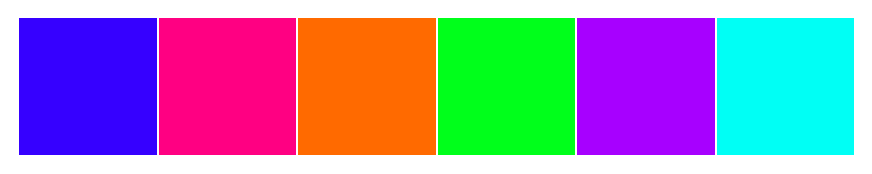

In [50]:
palette = HSV + [sns.color_palette('hsv', n_colors=13)[-3], sns.color_palette('hsv', n_colors=13)[6]]
sns.palplot(palette)

In [64]:
cpmerge_a = cp_merged.merge(cedar_related_baseline[['Peptide', 'HLA', 'EL_rank_mut', 'PRIME_score', 'nnalign_score']], left_on=['Peptide', 'HLA', 'EL_rank_mut'], right_on=['Peptide', 'HLA', 'EL_rank_mut'])
cpmerge_b = cp_merged.merge(prime_related_baseline[['Peptide', 'HLA', 'EL_rank_mut', 'PRIME_score', 'nnalign_score']], left_on=['Peptide', 'HLA', 'EL_rank_mut'], right_on=['Peptide', 'HLA', 'EL_rank_mut'])

In [69]:
cp_merged = pd.concat([cpmerge_a, cpmerge_b.query('Peptide not in @cpmerge_a.Peptide.unique()')])

### groupedby

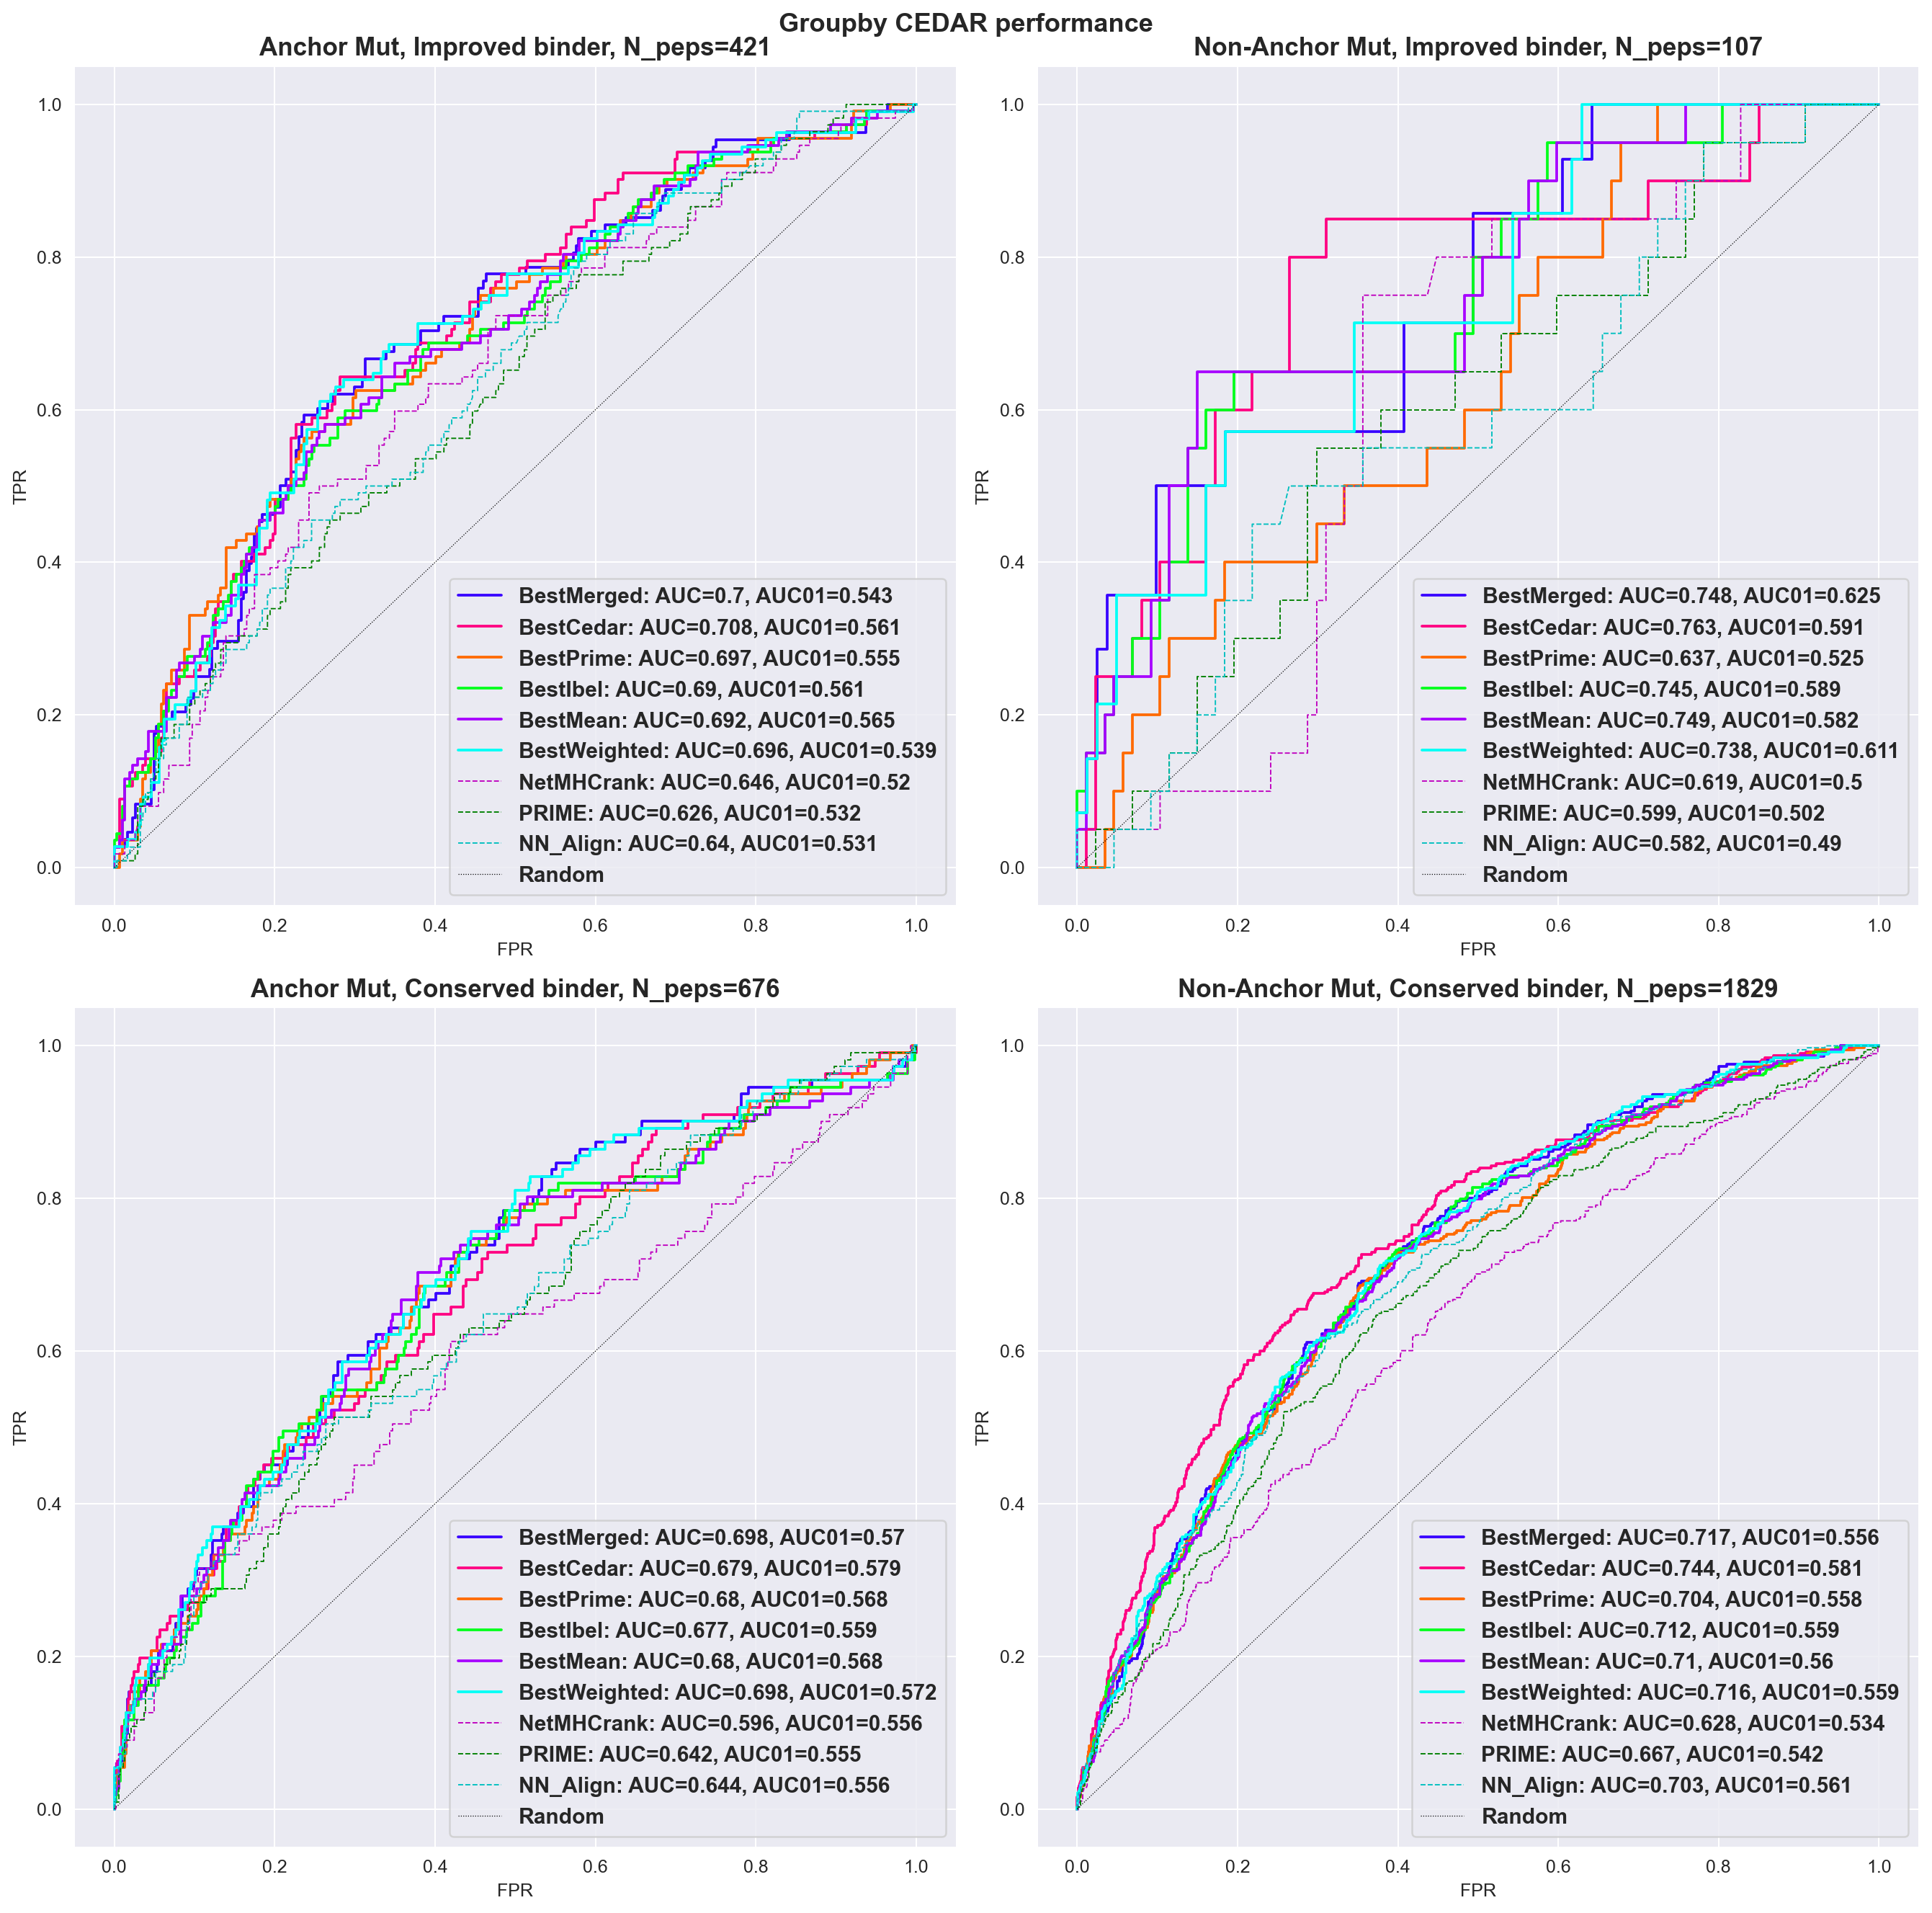

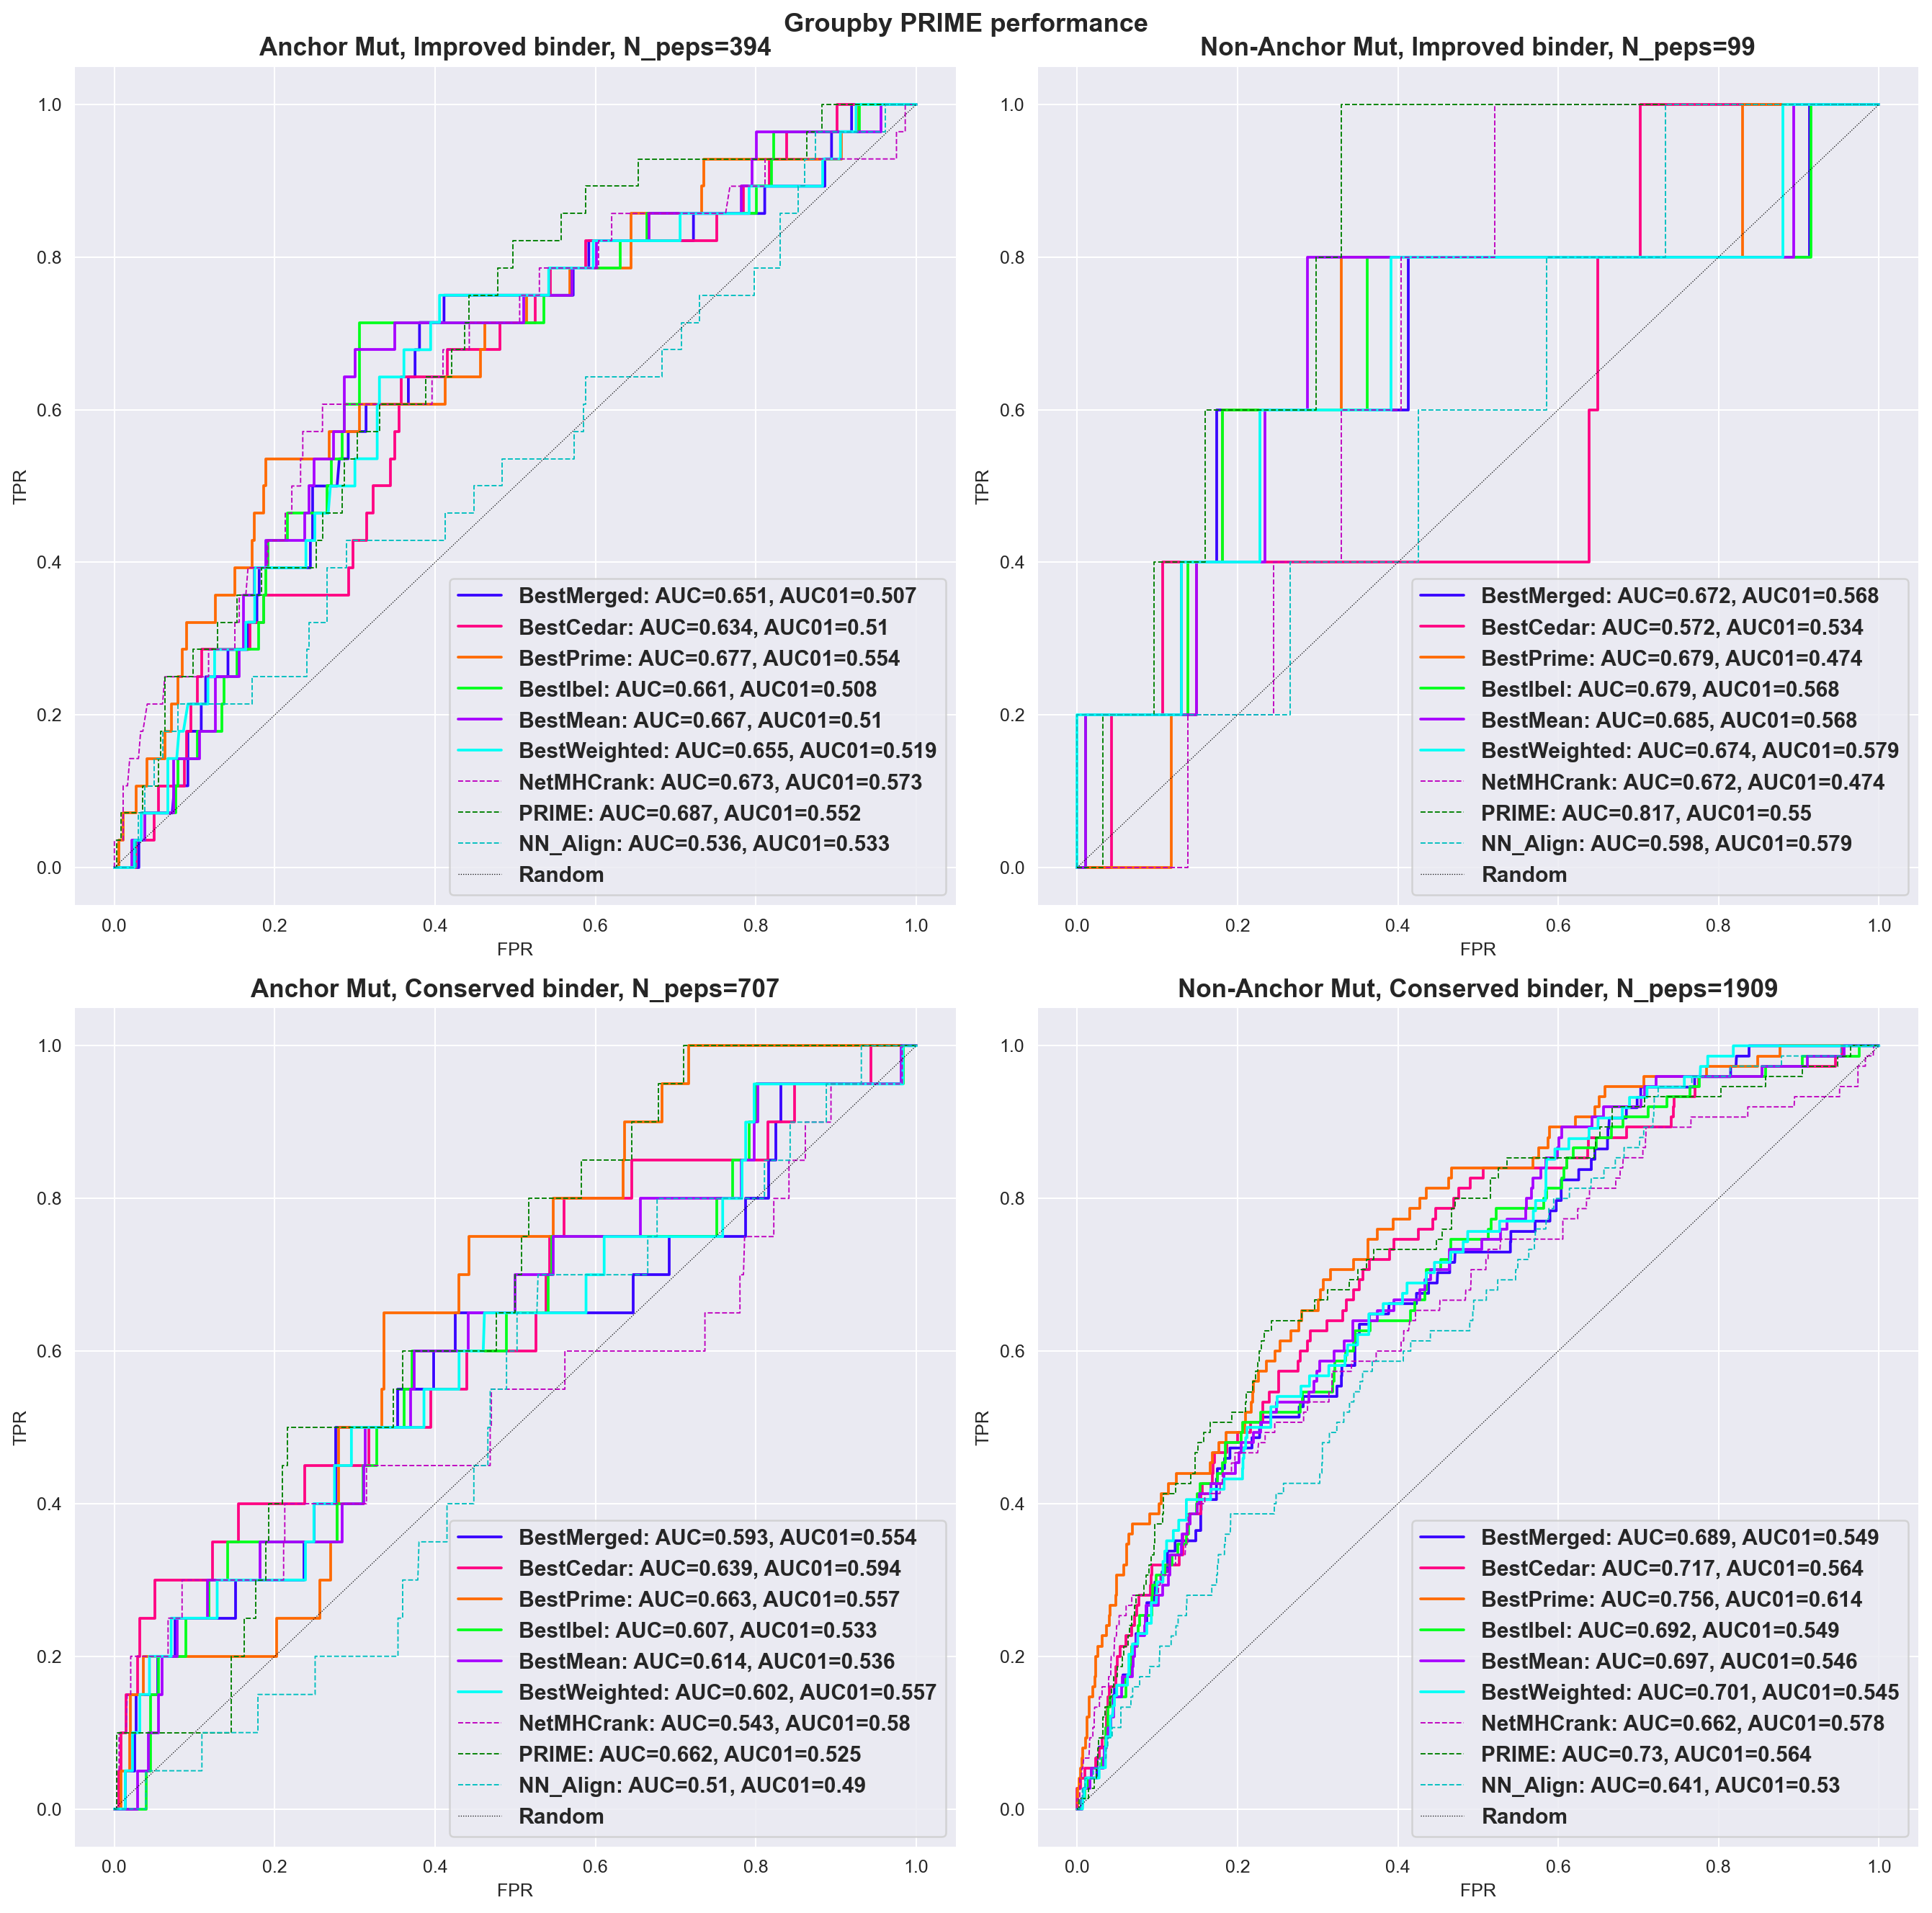

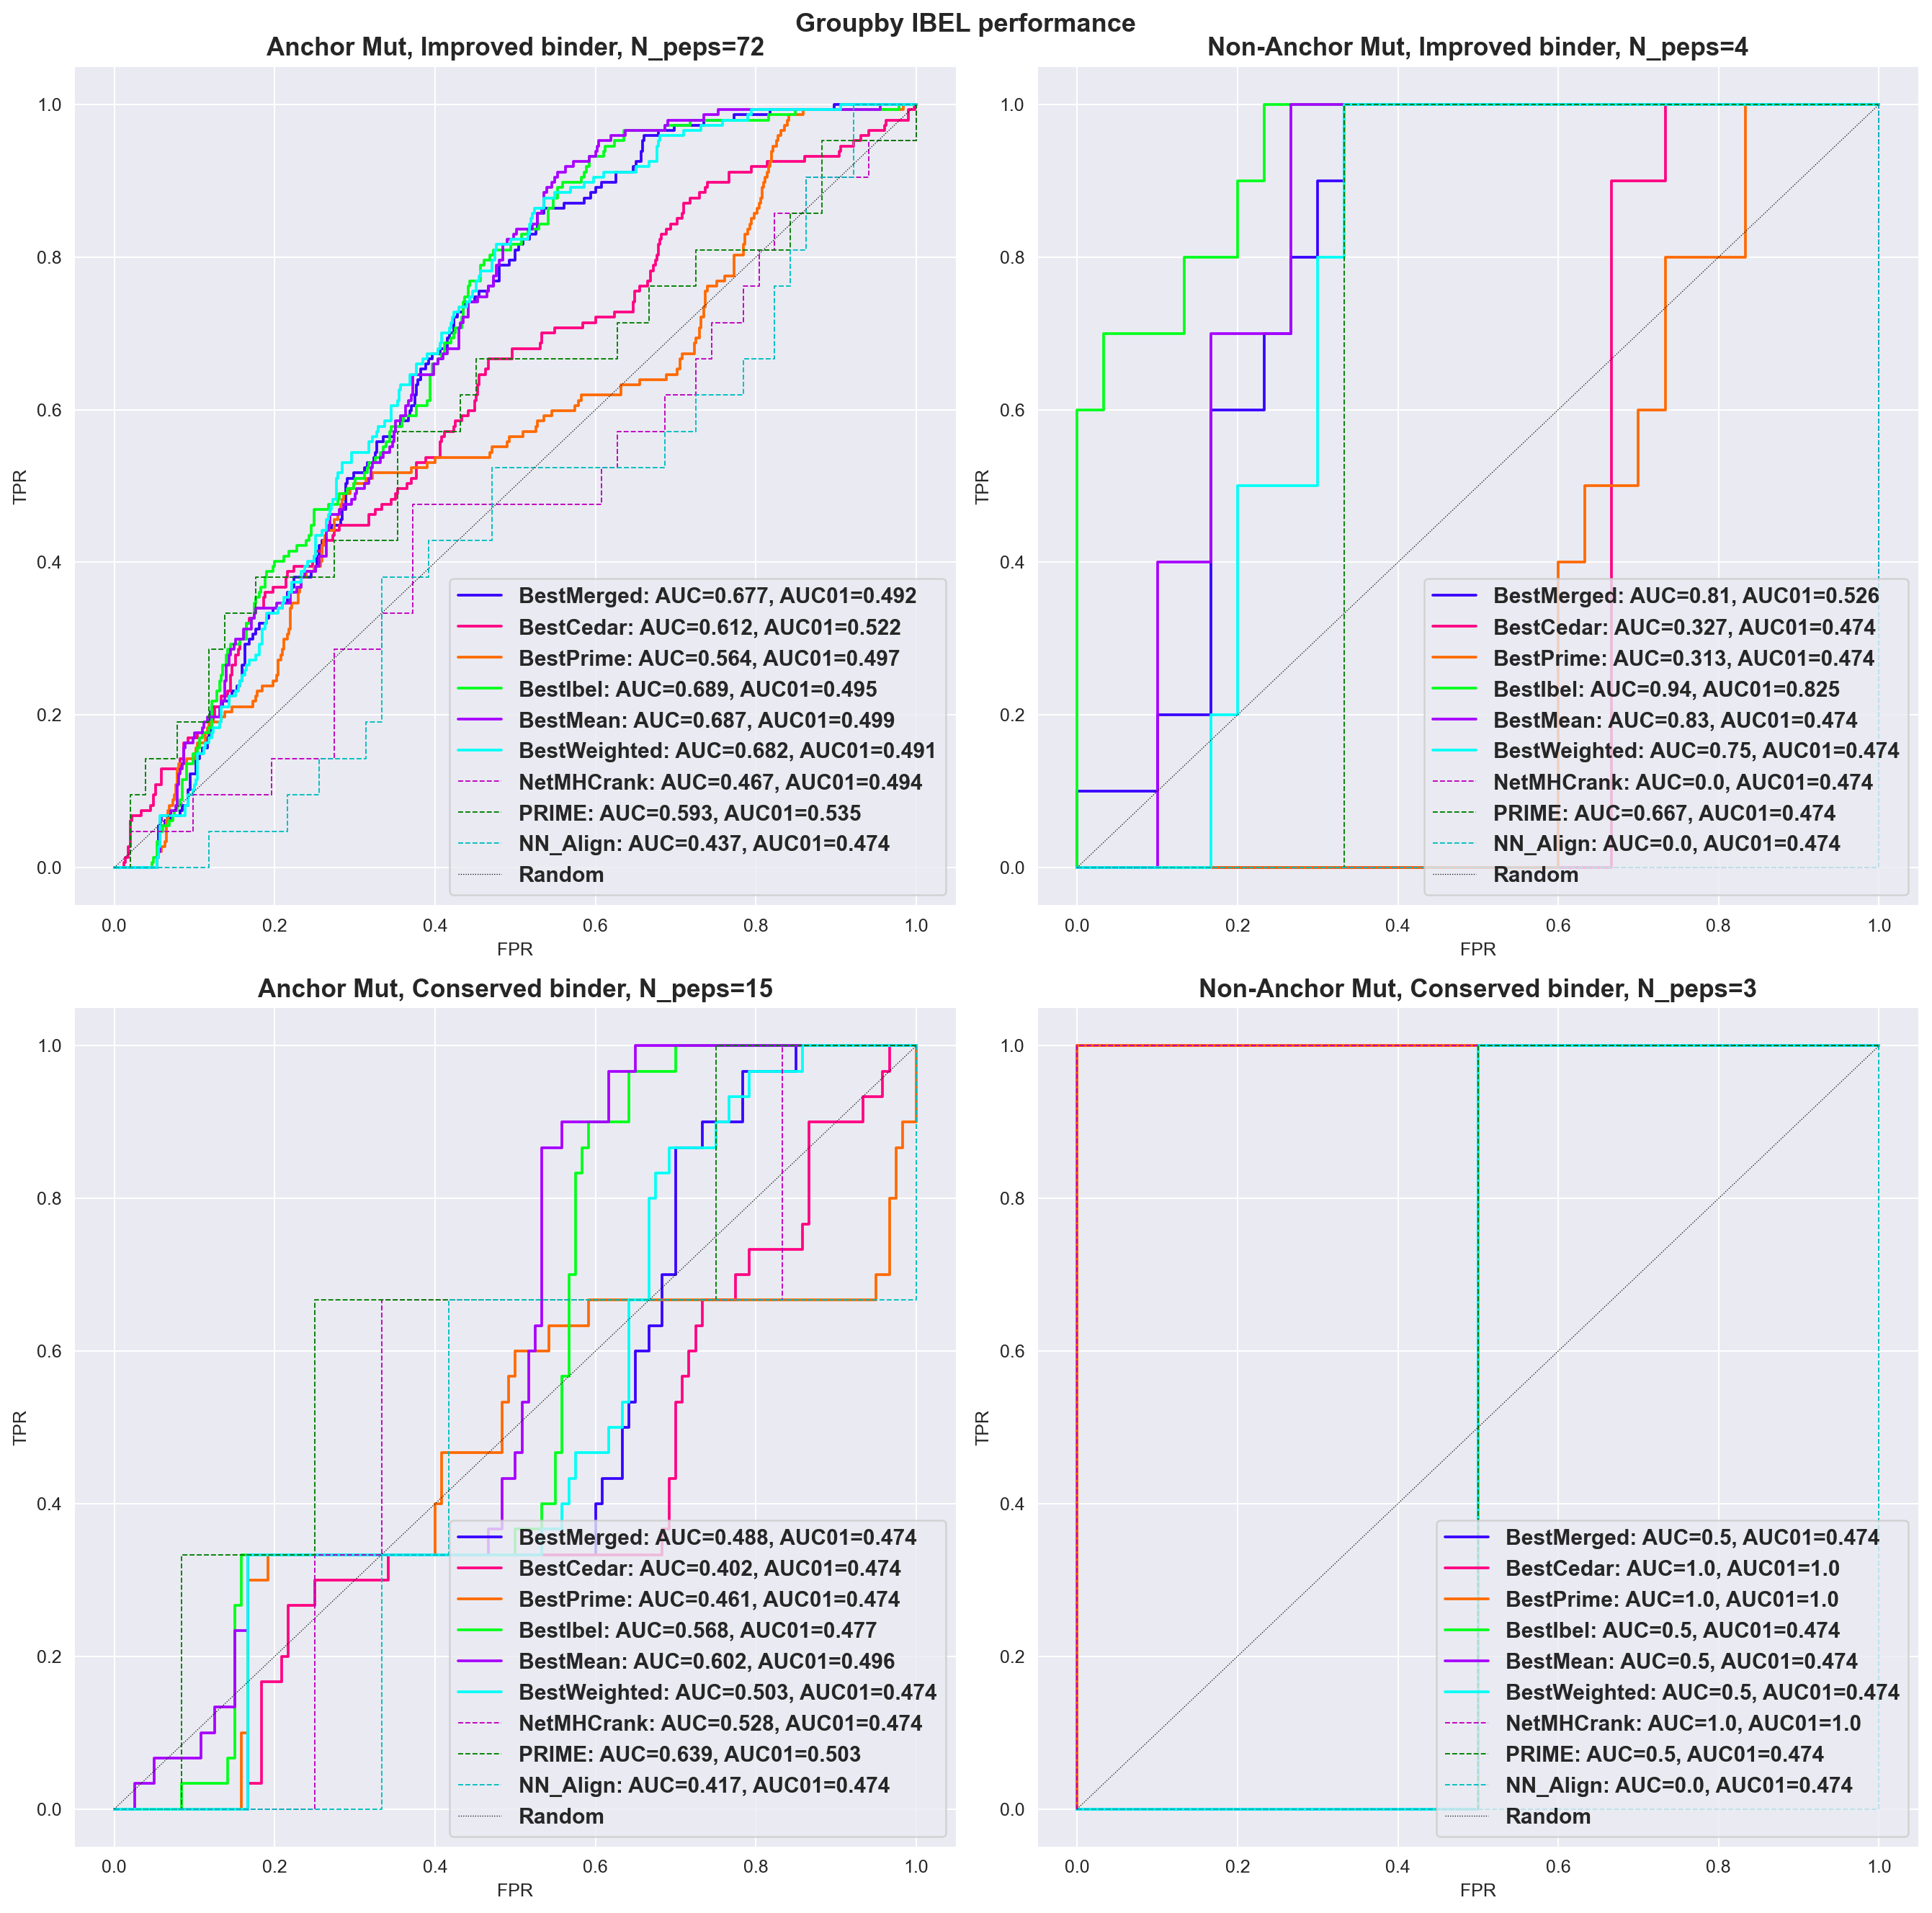

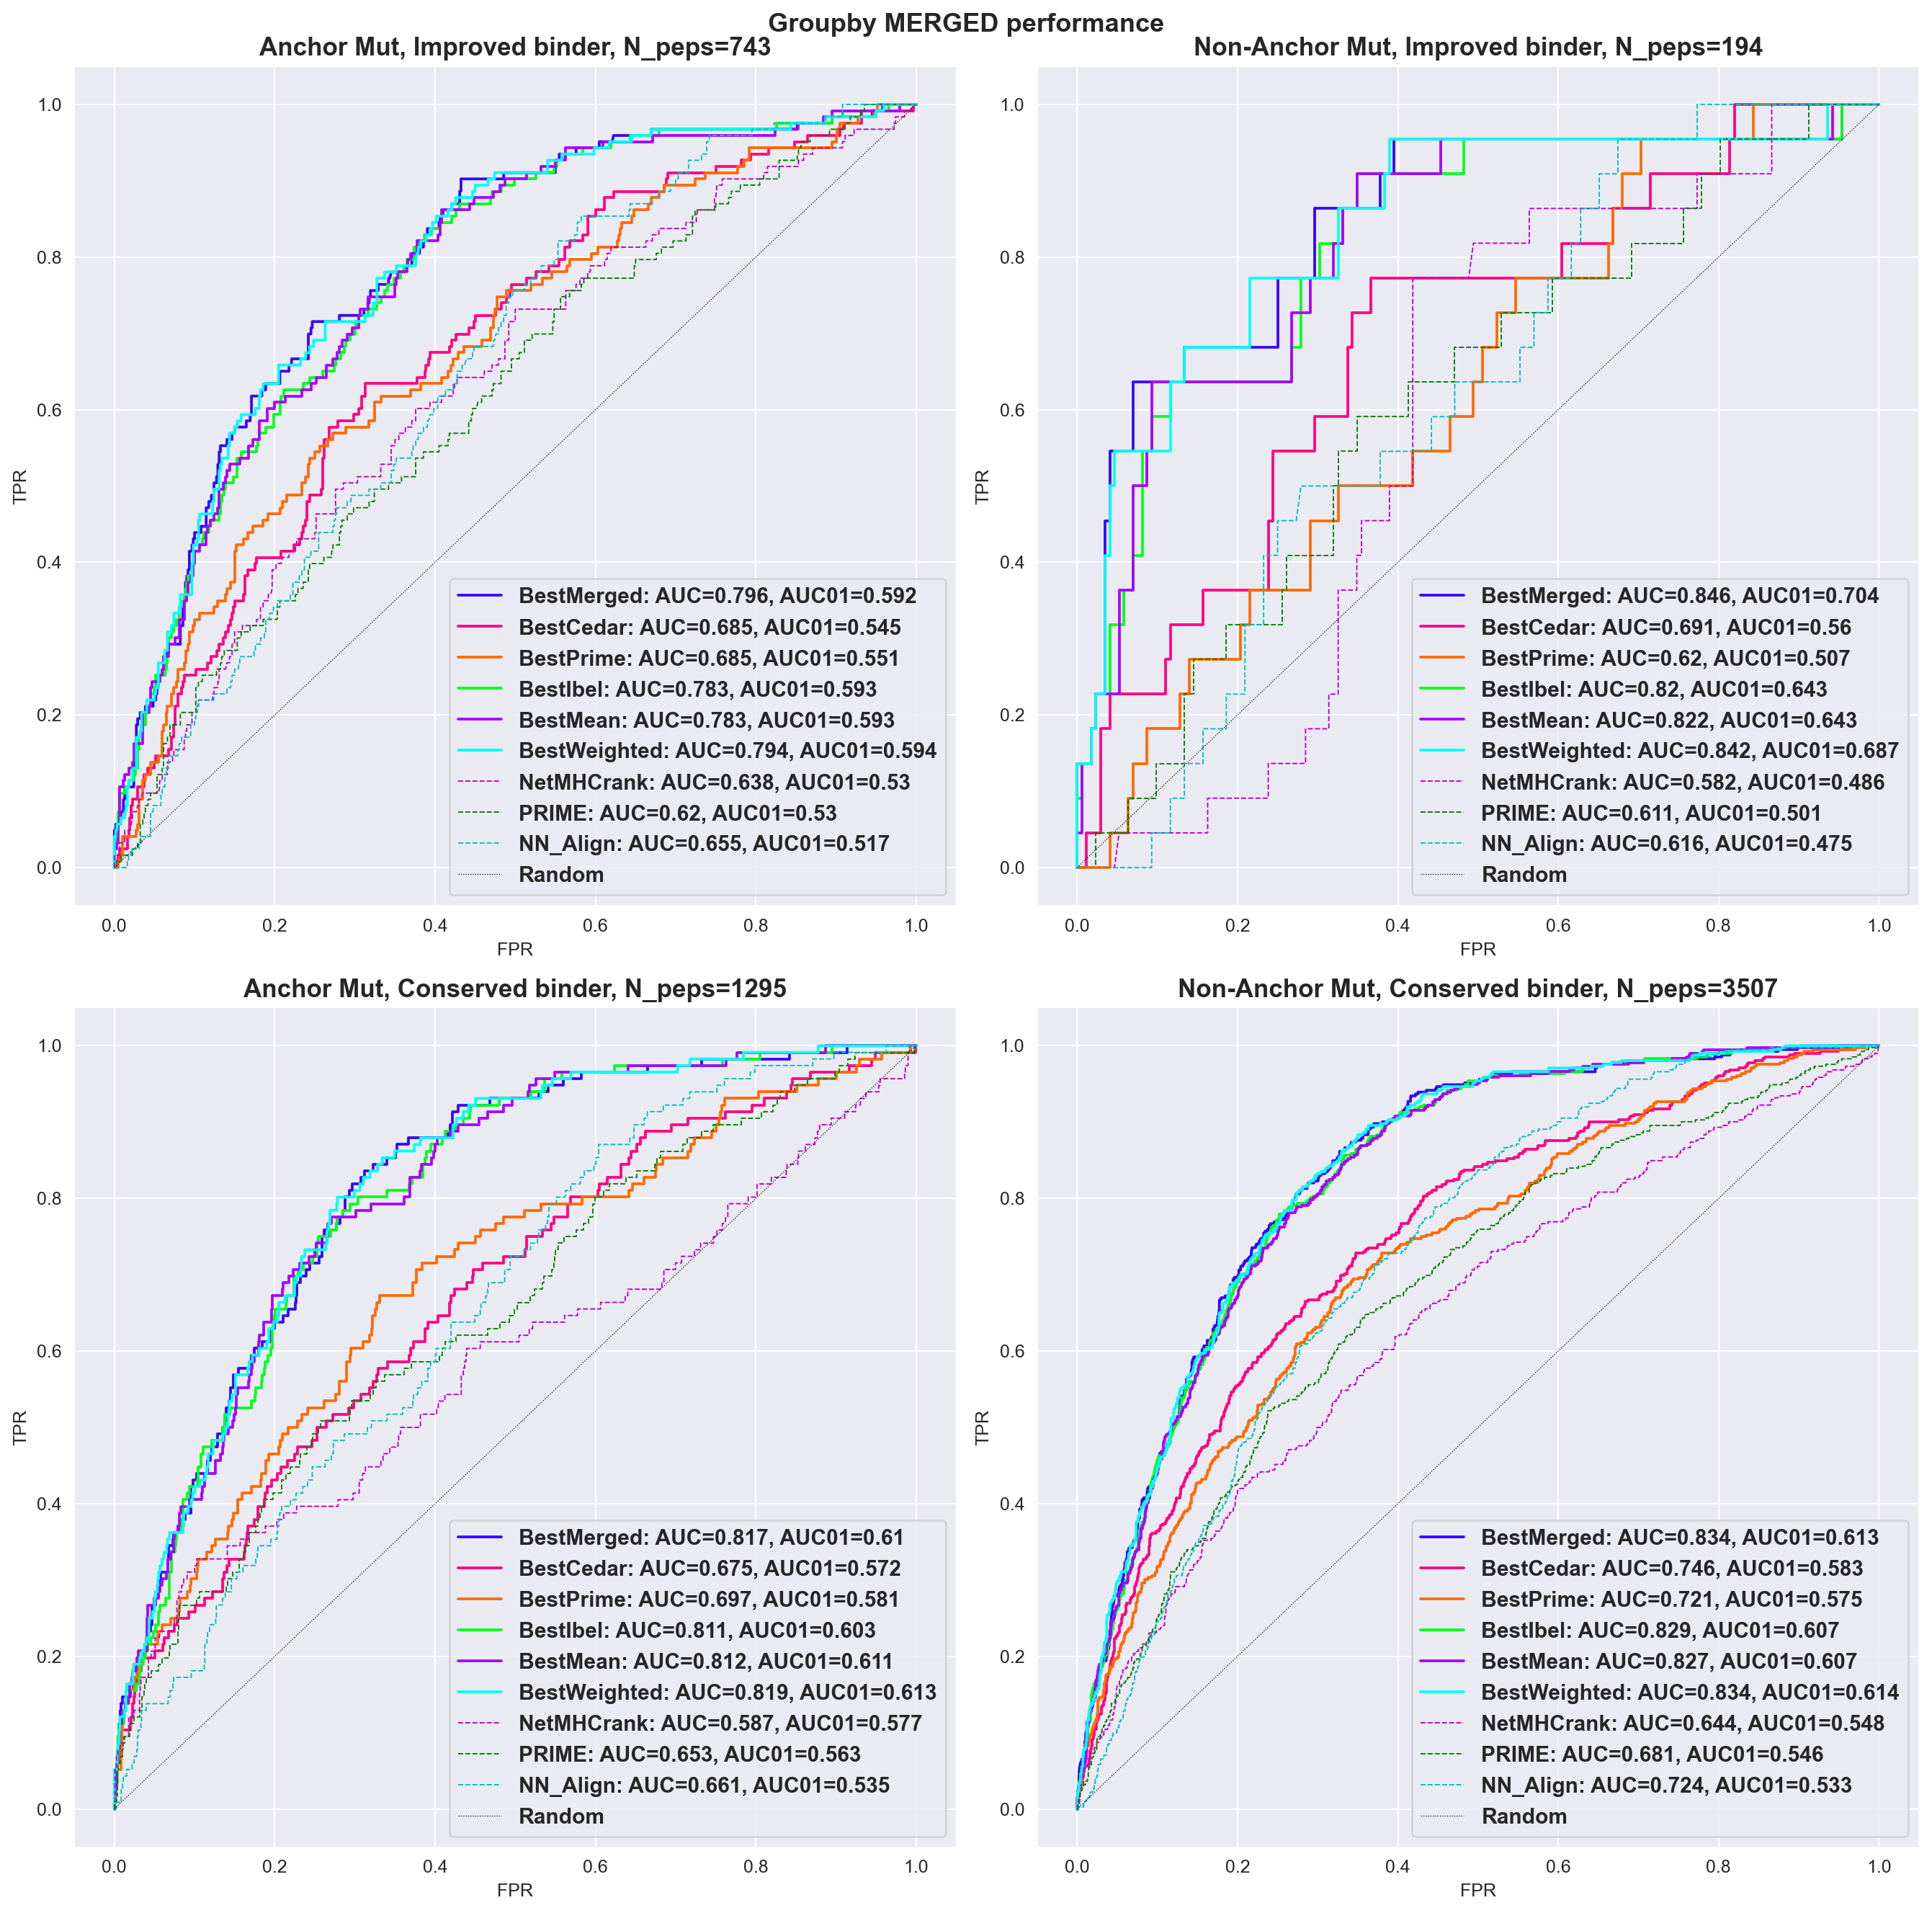

In [71]:
sns.set_palette(palette)
f_cedar,a_cedar = plt.subplots(2,2, figsize= (15,15))
ax_cedar = a_cedar.ravel()

f_prime,a_prime = plt.subplots(2,2, figsize= (15,15))
ax_prime = a_prime.ravel()

f_ibel, a_ibel = plt.subplots(2,2, figsize= (15,15))
ax_ibel = a_ibel.ravel()

f_merged, a_merged = plt.subplots(2,2, figsize= (15,15))
ax_merged = a_merged.ravel()
i=0
for binder in ['Improved', 'Conserved']:
    for anc in [True, False]:
        xd = 'Anchor Mut' if anc else 'Non-Anchor Mut'
        name = f'{xd}, {binder} binder'
        for k, df_ced, df_pr, df_ibel, df_merged in zip(['BestMerged','BestCedar', 'BestPrime', 'BestIbel', 'BestMean', 'BestWeighted'],
                                            [best_merged_cdt_cedar_preds, best_cedar_cdt_cedar_preds, best_prime_cdt_cedar_preds, best_ibel_cdt_cedar_preds, best_mean_cdt_cedar_preds, best_weighted_cdt_cedar_preds],
                                            [best_merged_cdt_prime_preds, best_cedar_cdt_prime_preds, best_prime_cdt_prime_preds, best_ibel_cdt_prime_preds, best_mean_cdt_prime_preds, best_weighted_cdt_prime_preds],
                                            [best_merged_cdt_ibel_preds, best_cedar_cdt_ibel_preds, best_prime_cdt_ibel_preds, best_ibel_cdt_ibel_preds, best_mean_cdt_ibel_preds, best_weighted_cdt_ibel_preds], 
                                            [best_merged_cdt_merged_preds, best_cedar_cdt_merged_preds, best_prime_cdt_merged_preds, best_ibel_cdt_merged_preds, best_mean_cdt_merged_preds, best_weighted_cdt_merged_preds]):
            
            values_cedar = get_roc(df_ced, 'pred','agg_label',  binder, anc)
            sns.lineplot(x=values_cedar['roc'][0], y=values_cedar['roc'][1], label=f"{k}: AUC={round(values_cedar['auc'],3)}, AUC01={round(values_cedar['auc01'],3)}", 
                         estimator = None, ax=ax_cedar[i])
            ax_cedar[i].set_title(f"{name}, N_peps={len(cedar_related.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_cedar[i].set_xlabel('FPR')
            ax_cedar[i].set_ylabel('TPR')
            
            values_prime = get_roc(df_pr, 'mean_pred', 'agg_label', binder, anc)
            sns.lineplot(x=values_prime['roc'][0], y=values_prime['roc'][1], label=f"{k}: AUC={round(values_prime['auc'],3)}, AUC01={round(values_prime['auc01'],3)}", 
                         estimator = None, ax=ax_prime[i])
            ax_prime[i].set_title(f"{name}, N_peps={len(prime_related.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_prime[i].set_xlabel('FPR')
            ax_prime[i].set_ylabel('TPR')
            
            
            values_ibel = get_roc(df_ibel, 'pred', 'agg_label', binder, anc)
            sns.lineplot(x=values_ibel['roc'][0], y=values_ibel['roc'][1], label=f"{k}: AUC={round(values_ibel['auc'],3)}, AUC01={round(values_ibel['auc01'],3)}", 
                         estimator = None, ax=ax_ibel[i])
            ax_ibel[i].set_title(f"{name}, N_peps={len(ibel.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_ibel[i].set_xlabel('FPR')
            ax_ibel[i].set_ylabel('TPR')
            
            values_merged = get_roc(df_merged, 'pred', 'agg_label', binder, anc)
            sns.lineplot(x=values_merged['roc'][0], y=values_merged['roc'][1], label=f"{k}: AUC={round(values_merged['auc'],3)}, AUC01={round(values_merged['auc01'],3)}", 
                         estimator = None, ax=ax_merged[i])
            ax_merged[i].set_title(f"{name}, N_peps={len(cp_merged.query('anchor_mutation==@anc and binder==@binder'))}", fontweight='semibold', fontsize=14)
            ax_merged[i].set_xlabel('FPR')
            ax_merged[i].set_ylabel('TPR')
        
        plot_related_baseline_roc(ax_cedar[i], cedar_related_baseline, binder, anc, auc01=True)
        plot_related_baseline_roc(ax_prime[i], prime_related_baseline ,binder, anc, auc01=True)
        plot_related_baseline_roc(ax_ibel[i], ibel, binder, anc, auc01=True)
        plot_related_baseline_roc(ax_merged[i], cp_merged, binder, anc, auc01=True)

        ax_cedar[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        ax_prime[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        ax_ibel[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        ax_merged[i].legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
        
        f_cedar.suptitle('Groupby CEDAR performance', fontweight='semibold', fontsize=14.5)
        f_cedar.tight_layout()
        f_prime.suptitle('Groupby PRIME performance', fontweight='semibold', fontsize=14.5)
        f_prime.tight_layout()
        f_ibel.suptitle('Groupby IBEL performance', fontweight='semibold', fontsize=14.5)
        f_ibel.tight_layout()
        f_merged.suptitle('Groupby MERGED performance', fontweight='semibold', fontsize=14.5)
        f_merged.tight_layout()
        i+=1

### Standalone

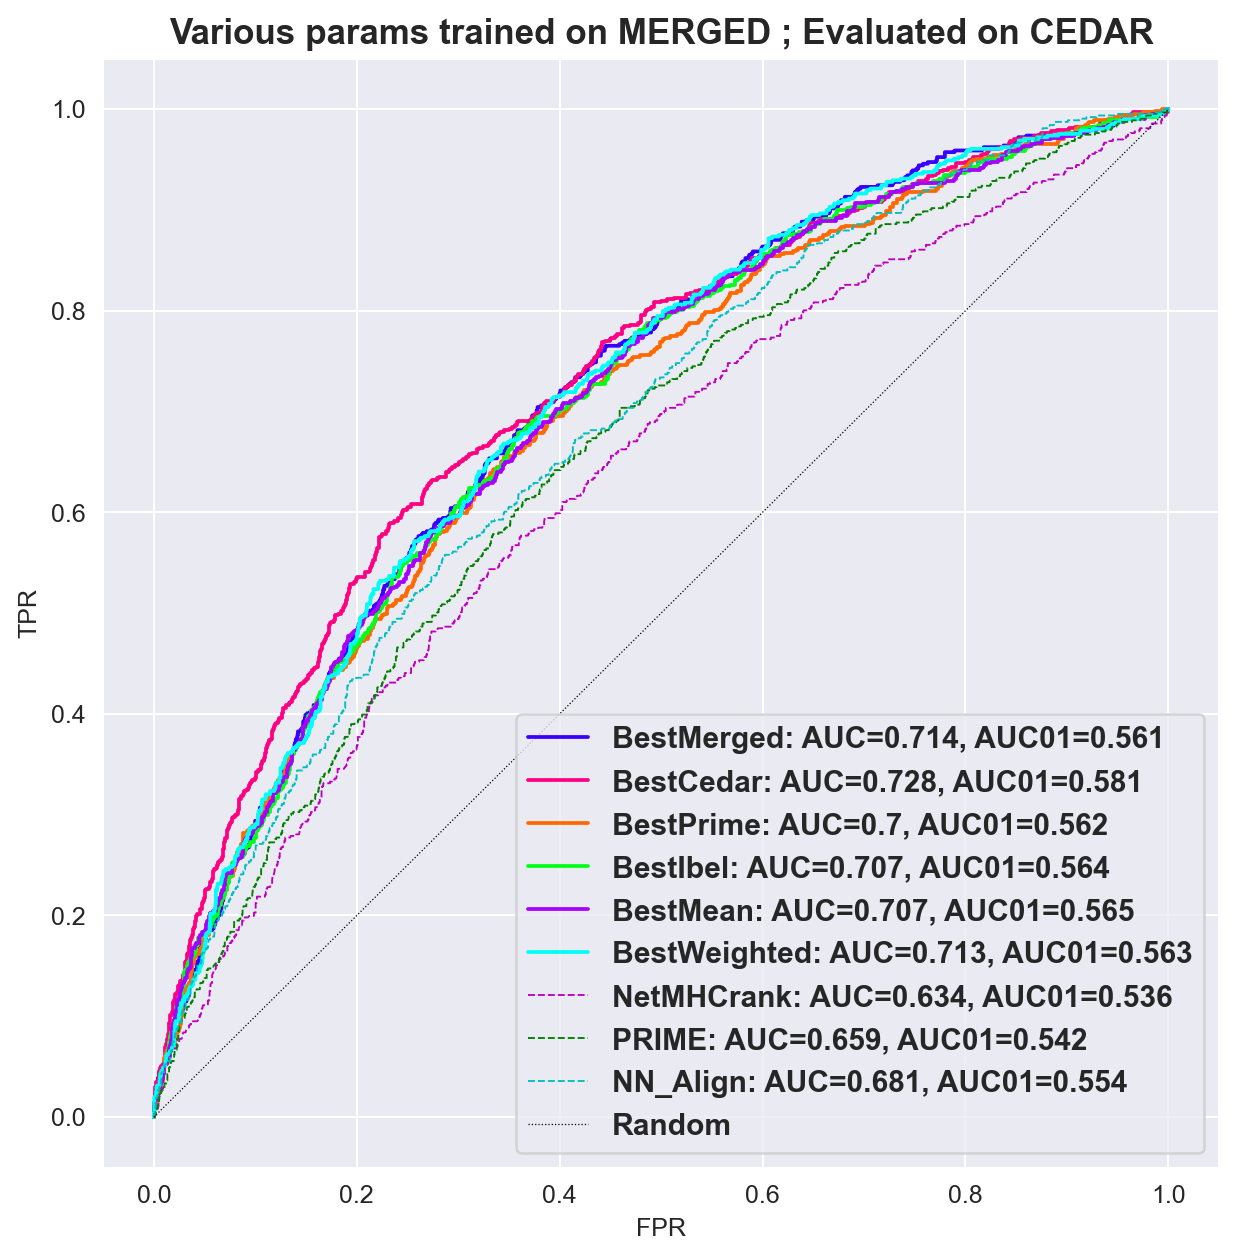

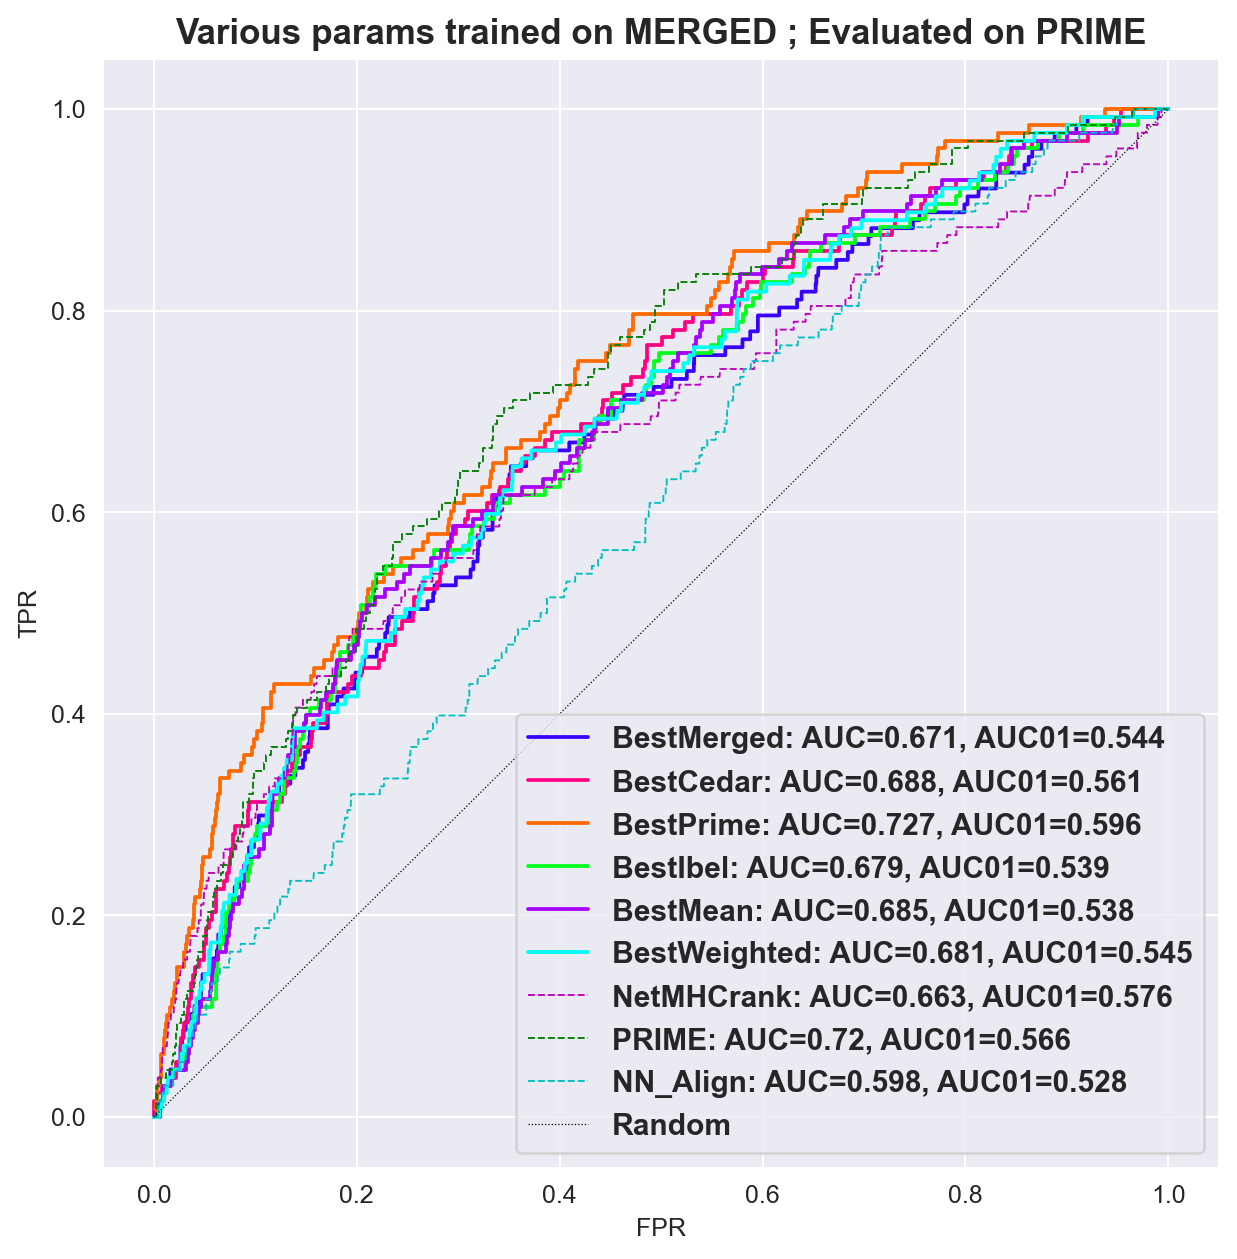

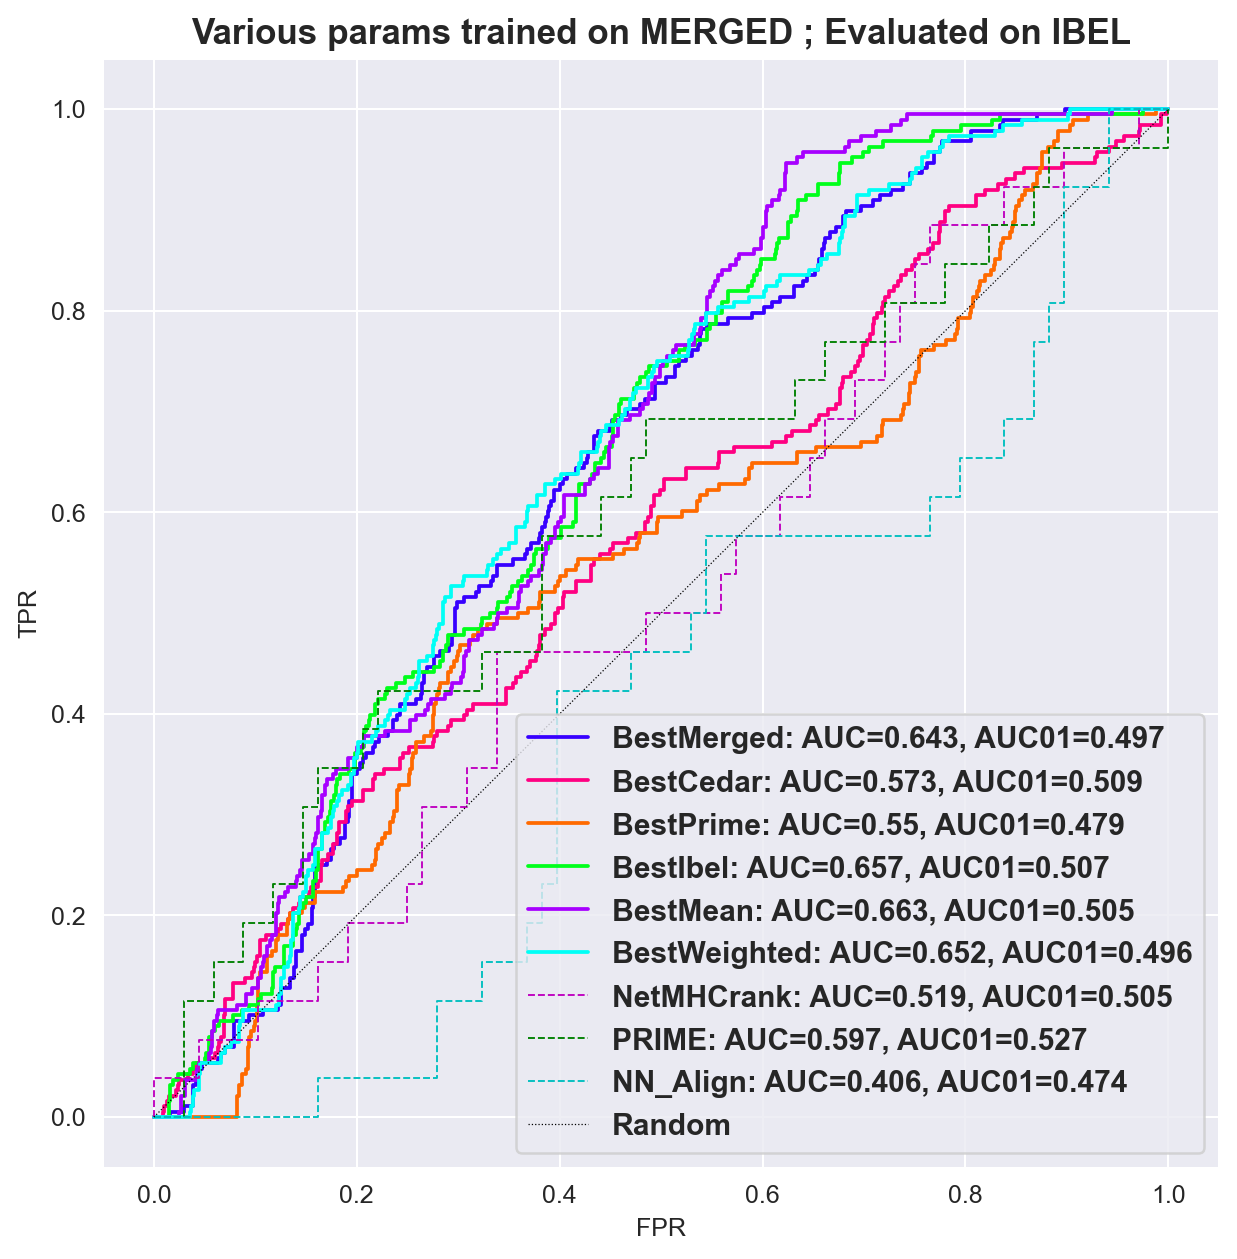

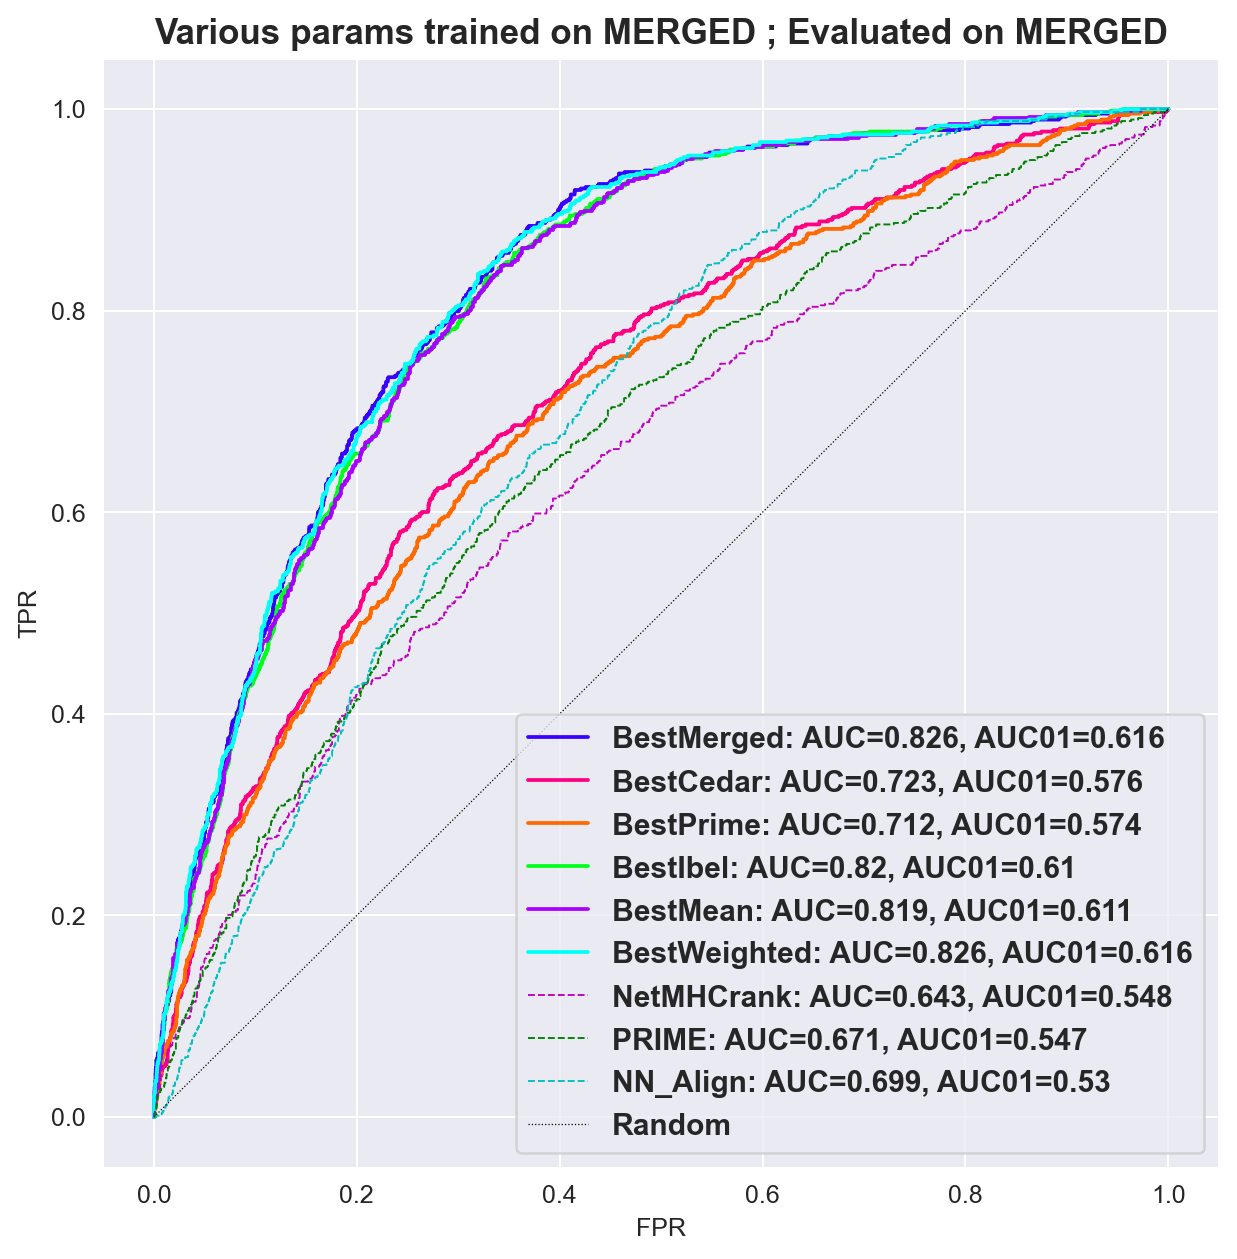

In [82]:
sns.set_palette(palette)
f_cedar,ax_cedar = plt.subplots(1,1, figsize=(8,8))

f_prime,ax_prime = plt.subplots(1,1, figsize=(8,8))

f_ibel, ax_ibel = plt.subplots(1,1, figsize=(8,8))

f_merged, ax_merged = plt.subplots(1,1, figsize=(8,8))
for k, df_ced, df_pr, df_ibel, df_merged in zip(['BestMerged','BestCedar', 'BestPrime', 'BestIbel', 'BestMean', 'BestWeighted'],
                                            [best_merged_cdt_cedar_preds, best_cedar_cdt_cedar_preds, best_prime_cdt_cedar_preds, best_ibel_cdt_cedar_preds, best_mean_cdt_cedar_preds, best_weighted_cdt_cedar_preds],
                                            [best_merged_cdt_prime_preds, best_cedar_cdt_prime_preds, best_prime_cdt_prime_preds, best_ibel_cdt_prime_preds, best_mean_cdt_prime_preds, best_weighted_cdt_prime_preds],
                                            [best_merged_cdt_ibel_preds, best_cedar_cdt_ibel_preds, best_prime_cdt_ibel_preds, best_ibel_cdt_ibel_preds, best_mean_cdt_ibel_preds, best_weighted_cdt_ibel_preds], 
                                            [best_merged_cdt_merged_preds, best_cedar_cdt_merged_preds, best_prime_cdt_merged_preds, best_ibel_cdt_merged_preds, best_mean_cdt_merged_preds, best_weighted_cdt_merged_preds]):
            
    values_cedar = get_roc(df_ced, 'pred','agg_label',  None, None)
    sns.lineplot(x=values_cedar['roc'][0], y=values_cedar['roc'][1], label=f"{k}: AUC={round(values_cedar['auc'],3)}, AUC01={round(values_cedar['auc01'],3)}", 
                 estimator = None, ax=ax_cedar)

    
    values_prime = get_roc(df_pr, 'mean_pred', 'agg_label', None, None)
    sns.lineplot(x=values_prime['roc'][0], y=values_prime['roc'][1], label=f"{k}: AUC={round(values_prime['auc'],3)}, AUC01={round(values_prime['auc01'],3)}", 
                 estimator = None, ax=ax_prime)
    
  
    values_ibel = get_roc(df_ibel, 'pred', 'agg_label', None, None)
    sns.lineplot(x=values_ibel['roc'][0], y=values_ibel['roc'][1], label=f"{k}: AUC={round(values_ibel['auc'],3)}, AUC01={round(values_ibel['auc01'],3)}", 
                 estimator = None, ax=ax_ibel)
    
    values_merged = get_roc(df_merged, 'pred', 'agg_label', None, None)
    sns.lineplot(x=values_merged['roc'][0], y=values_merged['roc'][1], label=f"{k}: AUC={round(values_merged['auc'],3)}, AUC01={round(values_merged['auc01'],3)}", 
                 estimator = None, ax=ax_merged)

ax_cedar.set_title("Various params trained on MERGED ; Evaluated on CEDAR", fontweight='semibold', fontsize=14)
ax_cedar.set_xlabel('FPR')
ax_cedar.set_ylabel('TPR')

ax_prime.set_title("Various params trained on MERGED ; Evaluated on PRIME", fontweight='semibold', fontsize=14)
ax_prime.set_xlabel('FPR')
ax_prime.set_ylabel('TPR')

ax_ibel.set_title("Various params trained on MERGED ; Evaluated on IBEL", fontweight='semibold', fontsize=14)
ax_ibel.set_xlabel('FPR')
ax_ibel.set_ylabel('TPR')

ax_merged.set_title("Various params trained on MERGED ; Evaluated on MERGED", fontweight='semibold', fontsize=14)
ax_merged.set_xlabel('FPR')
ax_merged.set_ylabel('TPR')
plot_related_baseline_roc(ax_cedar, cedar_related_baseline, binder=None, anchor_mutation=None, auc01=True)
plot_related_baseline_roc(ax_prime, prime_related_baseline ,binder=None, anchor_mutation=None, auc01=True)
plot_related_baseline_roc(ax_ibel, ibel, binder=None, anchor_mutation=None, auc01=True)
plot_related_baseline_roc(ax_merged, cp_merged, binder=None, anchor_mutation=None, auc01=True)

ax_cedar.legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
ax_prime.legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
ax_ibel.legend(loc='lower right',  prop={'weight':'semibold', 'size':12})
ax_merged.legend(loc='lower right',  prop={'weight':'semibold', 'size':12})


# Checking disagreement between top CEDAR / PRIME / MERGED models

check predictions for each set, false positives and negatives
What threshold ? 

In [95]:
# Reload just in case
dir_raw = '../output/221112_new_core_mutscores_mergedtrainset/raw/'

# Best cedar cdt
best_cedar_cdt_cedar_preds = get_fp_fn(pd.read_csv(f'{dir_raw}cedar_preds_{best_cedar_cdt}.csv'))
best_cedar_cdt_prime_preds = get_fp_fn(pd.read_csv(f'{dir_raw}prime_preds_{best_cedar_cdt}.csv'))
# best_cedar_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_cedar_cdt}.csv') 

# best prime cdt
best_prime_cdt_cedar_preds = get_fp_fn(pd.read_csv(f'{dir_raw}cedar_preds_{best_prime_cdt}.csv'))
best_prime_cdt_prime_preds = get_fp_fn(pd.read_csv(f'{dir_raw}prime_preds_{best_prime_cdt}.csv'))
# best_prime_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_prime_cdt}.csv') 

# # Best MERGED cdt
# best_merged_cdt_cedar_preds = pd.read_csv(f'{dir_raw}cedar_preds_{best_merged_cdt}.csv') 
# best_merged_cdt_prime_preds = pd.read_csv(f'{dir_raw}prime_preds_{best_merged_cdt}.csv') 
# best_merged_cdt_merged_preds = pd.read_csv(f'{dir_raw}merged_preds_{best_merged_cdt}.csv') 

In [91]:
def get_fp_fn(df, score='pred', target='agg_label'):
    score = 'pred' if 'pred' in df.columns else 'mean_pred' if 'mean_pred' in df.columns else score
    df['fp'] = df.apply(lambda x: (x[score]>.5 and x[target]==0), axis=1)
    df['fn'] = df.apply(lambda x: (x[score]<=.5 and x[target]==1), axis=1)
    return df

In [117]:
# Get the false positives and false negatives taken from
cedar_related_baseline['fp'] = 

Peptide        HLA  nnalign_score  MixMHCrank  PRIME_score  \
0     AAAAAAQQIQV  HLA-B0702        0.04789       4.676     0.008733   
1       AAAAQQIQV  HLA-B0702        0.11765       0.363     0.097263   
2       AAAAQQIQV  HLA-A0201        0.11765       0.363     0.097263   
3       AAHFTVLLY  HLA-A1101        0.31177       0.011     0.285331   
4       AAIAASRSV  HLA-C1203        0.17028       0.070     0.166057   
...           ...        ...            ...         ...          ...   
3028  YYNFEGDIALL  HLA-A2402        0.13192       0.674     0.055695   
3029    YYPGKKEPF  HLA-A2402        0.16206       0.037     0.196378   
3030    YYSKNLNSF  HLA-A2402        0.17273       0.005     0.294321   
3031   YYSKNLNSFF  HLA-A2402        0.10953       0.055     0.187679   
3032    YYSPQAQTL  HLA-A2402        0.17326       0.010     0.255739   

     MixMHCallele  EL_rank_mut  agg_label  fold  BA_rank  ...   seq_id  \
0           B5601       3.9712          0     6  11.9024  ...     seq1   
1           C1203       4.9092          0     6   0.3045  ...     seq3   
2           C1203       1.9555          0     6   0.3045  ...     seq2   
3           A2902       0.4196          0     9   0.1083  ...     seq4   
4           C0303       0.0591          0     6   0.0580  ...     seq5   
...           ...          ...        ...   ...      ...  ...      ...   
3028        A2402       0.6247          0     9   0.6703  ...  seq3029   
3029        C1402       0.0965          0     1   0.0750  ...  seq3030   
3030        A2402       0.0033          1     3   0.0086  ...  seq3031   
3031        A2402       0.0033          1     3   0.0122  ...  seq3032   
3032        C1402       0.0052          0     4   0.0088  ...  seq3033   

     total_count trainset trueHLA_EL_rank    wild_type  wt_EL_rank    wt_core  \
0              1    cedar         26.7692  AAAAAAQQLQV     25.5667  AAAAAQLQV   
1              1    cedar          4.9092    AAAAQQLQV      4.7746  AAAAQQLQV   
2              1    cedar          1.9555    AAAAQQLQV      2.2847  AAAAQQLQV   
3              1    cedar          0.4196    AAHFTALLY      0.5881  AAHFTALLY   
4              1    cedar          0.0591    AAIAASRSA      1.1729  AAIAASRSA   
...          ...      ...             ...          ...         ...        ...   
3028           2    cedar          0.6247  SYNFEGDIALL      0.7584  SYNGDIALL   
3029           2    cedar          0.0965    YYSGKKEPF      0.0817  YYSGKKEPF   
3030           1    cedar          0.0033    YYSKNLNSS      4.6860  YYSKNLNSS   
3031           2    cedar          0.0310   YYSKNLNSSF      0.0350  YYSKNLNSF   
3032           1    cedar          0.0052    YYSPQAQTP      1.3642  YYSPQAQTP   

      wt_true  diff_label_from_prime  dataset  
0        True                      0    CEDAR  
1        True                      0    CEDAR  
2        True                      0    CEDAR  
3        True                      0    CEDAR  
4        True                      0    CEDAR  
...       ...                    ...      ...  
3028     True                      0    CEDAR  
3029     True                      0    CEDAR  
3030     True                      0    CEDAR  
3031     True                      0    CEDAR  
3032     True                      0    CEDAR  

[3033 rows x 54 columns]

<AxesSubplot:ylabel='Frequency'>

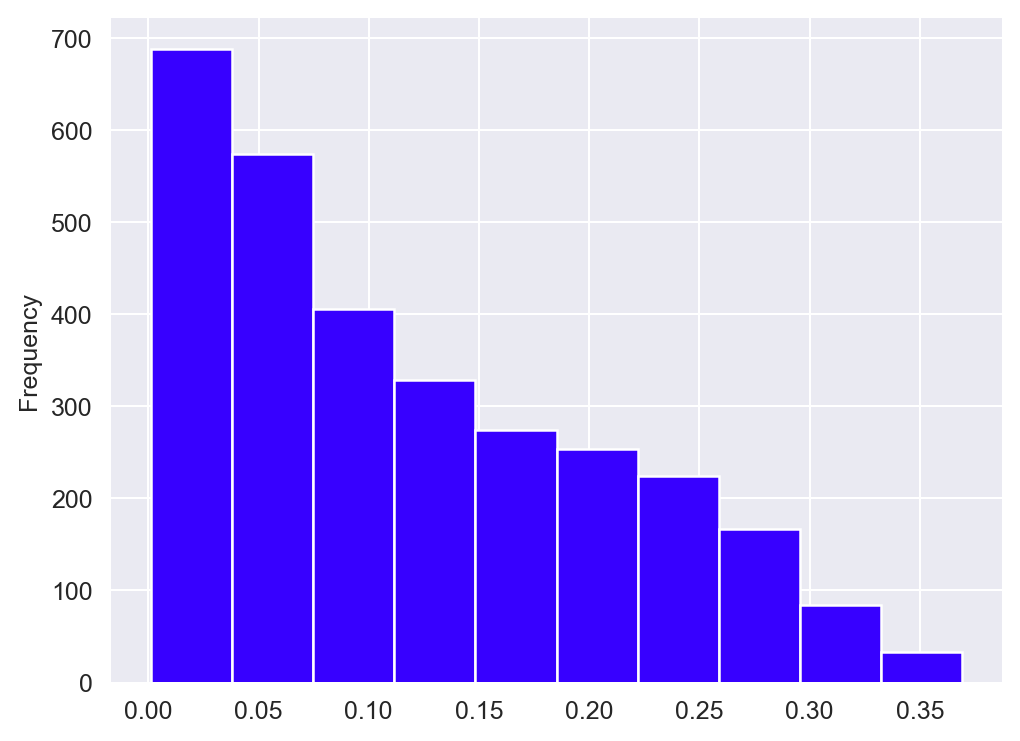

In [123]:
cedar_related_baseline.PRIME_score.plot(kind='hist')

In [126]:
best_cedar_cdt_cedar_preds.pred.describe()

count    3033.000000
mean        0.122798
std         0.071014
min         0.027270
25%         0.072385
50%         0.103016
75%         0.153595
max         0.522047
Name: pred, dtype: float64

In [125]:
prime_related_baseline.PRIME_score.describe()

count    3109.000000
mean        0.107891
std         0.084132
min         0.000287
25%         0.037986
50%         0.082493
75%         0.163341
max         0.380764
Name: PRIME_score, dtype: float64

In [114]:
fp_fn = {'fn': {'best_cedar':{},
                'best_prime':{}},
         'fp': {'best_cedar':{},
                'best_prime':{}}}

for f in ['fn', 'fp']:
    fp_fn[f]['PRIME']['cedar']
    fp_fn[f]['best_cedar']['cedar'] = best_cedar_cdt_cedar_preds.query(f'{f}')
    fp_fn[f]['best_cedar']['prime'] = best_cedar_cdt_prime_preds.query(f'{f}')
    fp_fn[f]['best_prime']['cedar'] = best_prime_cdt_cedar_preds.query(f'{f}')
    fp_fn[f]['best_prime']['prime'] = best_prime_cdt_prime_preds.query(f'{f}')

In [154]:
pd.set_option('display.max_rows', 10)

False

In [172]:
prime_related_baseline['pred']=0
merged_preds_prime = prime_related_baseline.merge(best_cedar_cdt_prime_preds.rename(columns={'mean_pred':'pred'})[['Peptide', 'HLA', 'pred']],
                                                  left_on = ['Peptide', 'HLA'], right_on = ['Peptide', 'HLA'],
                                                  suffixes=['', '_bestCedar'])\
                                           .merge(best_prime_cdt_prime_preds.rename(columns={'mean_pred':'pred'})[['Peptide', 'HLA', 'pred']],
                                                  left_on = ['Peptide', 'HLA'], right_on = ['Peptide', 'HLA'],
                                                  suffixes=['', '_bestPrime']).drop(columns=['pred'])

cedar_related_baseline['pred']=0
merged_preds_cedar = cedar_related_baseline.merge(best_cedar_cdt_cedar_preds[['Peptide', 'HLA', 'pred']],
                                                  left_on = ['Peptide', 'HLA'], right_on = ['Peptide', 'HLA'],
                                                  suffixes=['', '_bestCedar'])\
                                           .merge(best_prime_cdt_cedar_preds[['Peptide', 'HLA', 'pred']],
                                                  left_on = ['Peptide', 'HLA'], right_on = ['Peptide', 'HLA'],
                                                  suffixes=['', '_bestPrime']).drop(columns=['pred'])

In [187]:
sorted(cedar_related.columns)

['BA_rank',
 'BA_score',
 'EL_rank_mut',
 'EL_rank_wt',
 'HLA',
 'HLA_full',
 'PMIDs',
 'Peptide',
 'Peptide_mut',
 'Peptide_wt',
 'Pos_mut',
 'Pos_wt',
 'Related Object_Ending Position',
 'Related Object_Starting Position',
 'VHSE1',
 'VHSE3',
 'VHSE7',
 'VHSE8',
 'agg_label',
 'aliphatic_index',
 'anchor_mutation',
 'binder',
 'blsm_mut_score',
 'boman',
 'core',
 'core_blsm_mut_score',
 'core_mut',
 'core_mutation_position',
 'core_mutation_score',
 'core_wt',
 'dissimilarity_score',
 'fold',
 'hydrophobicity',
 'icore',
 'icore_mut',
 'icore_wt',
 'isoelectric_point',
 'label',
 'len',
 'len_icore_mut',
 'len_icore_wt',
 'len_pep_mut',
 'len_pep_wt',
 'len_wt',
 'mhc_anchor',
 'mut_wt_sim',
 'mutation_position',
 'mutation_score',
 'mutation_type',
 'percentage_pos',
 'pred_EL_rank',
 'pred_EL_score',
 'pred_HLA',
 'ratio_rank',
 'responses',
 'seq_id',
 'total_count',
 'trainset',
 'trueHLA_EL_rank',
 'wild_type',
 'wt_EL_rank',
 'wt_core',
 'wt_true']

In [179]:
cols_ = [['Peptide', 'HLA', 'agg_label', 'pred_bestCedar', 'pred_bestPrime', 'PRIME_score', 'EL_rank_mut', 'EL_rank_wt',
          'anchor_mutation', 'binder', 'core_mut', 'core_wt', 'icore_mut', 'icore_wt', 'len']]
feat_cols = [

SyntaxError: incomplete input (2734204237.py, line 3)

In [151]:
fp_fn_rank = {'fn': {'best_cedar':{},
                     'best_prime':{},
                     'PRIME':{}},
              'fp': {'best_cedar':{},
                     'best_prime':{},
                     'PRIME':{}}}

X2p_cedar = 0.02*len(cedar_related_baseline)
X2p_prime = 0.02*len(prime_related_baseline)
for f in ['fn', 'fp']:
    label = 0 if f=='fp' else 1
    ascending = bool(label)
    fp_fn_rank[f]['PRIME']['cedar'] = cedar_related_baseline.query('agg_label==@label').sort_values('PRIME_score', ascending=ascending).head(int(X2p_cedar))
    fp_fn_rank[f]['PRIME']['prime'] = prime_related_baseline.query('agg_label==@label').sort_values('PRIME_score', ascending=ascending).head(int(X2p_prime))
    
    fp_fn_rank[f]['best_cedar']['cedar'] = best_cedar_cdt_cedar_preds.query(f'agg_label==@label').sort_values('pred', ascending=ascending).head(int(X2p_cedar))
    fp_fn_rank[f]['best_cedar']['prime'] = best_cedar_cdt_prime_preds.query(f'agg_label==@label').sort_values('mean_pred', ascending=ascending).head(int(X2p_prime))
    fp_fn_rank[f]['best_prime']['cedar'] = best_prime_cdt_cedar_preds.query(f'agg_label==@label').sort_values('pred', ascending=ascending).head(int(X2p_cedar))
    fp_fn_rank[f]['best_prime']['prime'] = best_prime_cdt_prime_preds.query(f'agg_label==@label').sort_values('mean_pred', ascending=ascending).head(int(X2p_prime))

In [156]:
len(fp_fn_rank[f]['best_prime']['prime']), len( fp_fn_rank[f]['best_cedar']['prime']), len(fp_fn_rank[f]['PRIME']['prime'])

(62, 62, 62)

In [155]:
cols_interest = [['Peptide', 'HLA', 'target', 'EL_rank_mut', 'EL_rank_
fp_fn_rank['fn']['best_cedar']['cedar']

Peptide        HLA  EL_rank_mut  agg_label  fold  BA_rank  BA_score  \
1178   STPLPGTRVR  HLA-A1101       0.8484          1     9   1.7173    0.4706   
1840  APARLERRHSA  HLA-B0702       0.4594          1     5   0.7565    0.2702   
1938   KPKKENLWRM  HLA-B0702       0.4590          1     4   0.7167    0.4500   
15      ASMPSSPPL  HLA-B1501       2.2354          1     2   0.0275    0.8281   
2677  SSEDDGFFLGK  HLA-A1101       0.7154          1     8   0.6193    0.5648   
...           ...        ...          ...        ...   ...      ...       ...   
1419  MLLENKAVEKA  HLA-A0201       1.2103          1     6   3.0039    0.4133   
2413   YEGQVISNGF  HLA-B4402       0.5454          1     2   0.1352    0.4061   
1418   MLLENKAVEK  HLA-A0301       0.5810          1     6   0.2058    0.6217   
1128   QIIHTYSNTV  HLA-A0206       0.7481          1     7   0.9990    0.4367   
254    TMIEEYDSGL  HLA-A0201       2.2537          1     8   0.6806    0.6962   

      EL_rank_wt     HLA_full                                         PMIDs  \
1178      0.7577  HLA-A*11:01                             34244308,34244308   
1840      6.6294  HLA-B*07:02                    27827318,26901407,26901407   
1938      0.4129  HLA-B*07:02                                      27198675   
15        1.2900  HLA-B*15:01  29545564,29545564,29643231,29643231,29643231   
2677      9.8420  HLA-A*11:01                             32582212,32582212   
...          ...          ...                                           ...   
1419      2.1861  HLA-A*02:01                                      31511069   
2413      9.6176  HLA-B*44:02                                      30906654   
1418      0.4571  HLA-A*03:01                                      31511069   
1128      1.1144  HLA-A*02:06                             34281881,34281881   
254       2.4307  HLA-A*02:01                                      31511069   

      ... total_count trainset  trueHLA_EL_rank    wild_type  wt_EL_rank  \
1178  ...           2    cedar           0.8484   STPPPGTRVR      0.7577   
1840  ...           3    cedar           0.4594  ALARLERRHSA     18.0390   
1938  ...           1    cedar           0.4590   KPKKENLRRM      0.4129   
15    ...           5    cedar           2.2354    AIMPSSPPL      1.2900   
2677  ...           2    cedar           0.7154  SSEDDGFFLGE     27.0000   
...   ...         ...      ...              ...          ...         ...   
1419  ...           1    cedar           1.2103  MLLENKAVKKA      2.1861   
2413  ...           1    cedar           0.5454   YGGQVISNGF     30.5714   
1418  ...           1    cedar           0.5810   MLLENKAVKK      0.4571   
1128  ...           2    cedar           4.3557   QIIHTDSNTV      3.7308   
254   ...           1    cedar           2.2537   TMIEEDDSGL      2.4307   

        wt_core  wt_true      pred     fp    fn  
1178  STPPPGTRR     True  0.027270  False  True  
1840  ALAERRHSA     True  0.029754  False  True  
1938  KPKKENLRM     True  0.043052  False  True  
15    AIMPSSPPL     True  0.043398  False  True  
2677  SSDGFFLGE     True  0.044334  False  True  
...         ...      ...       ...    ...   ...  
1419  MLLEAVKKA     True  0.071227  False  True  
2413  YGGQVSNGF     True  0.071369  False  True  
1418  MLLNKAVKK     True  0.071580  False  True  
1128  QIIHDSNTV     True  0.072661  False  True  
254   TMIEEDSGL     True  0.072931  False  True  

[60 rows x 58 columns]

In [475]:
tmp_core = df_results.query('(weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="icore_mut" and key in @core_keys')
tmp_non = df_results.query('(weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="Peptide" and key in @non_core_keys')

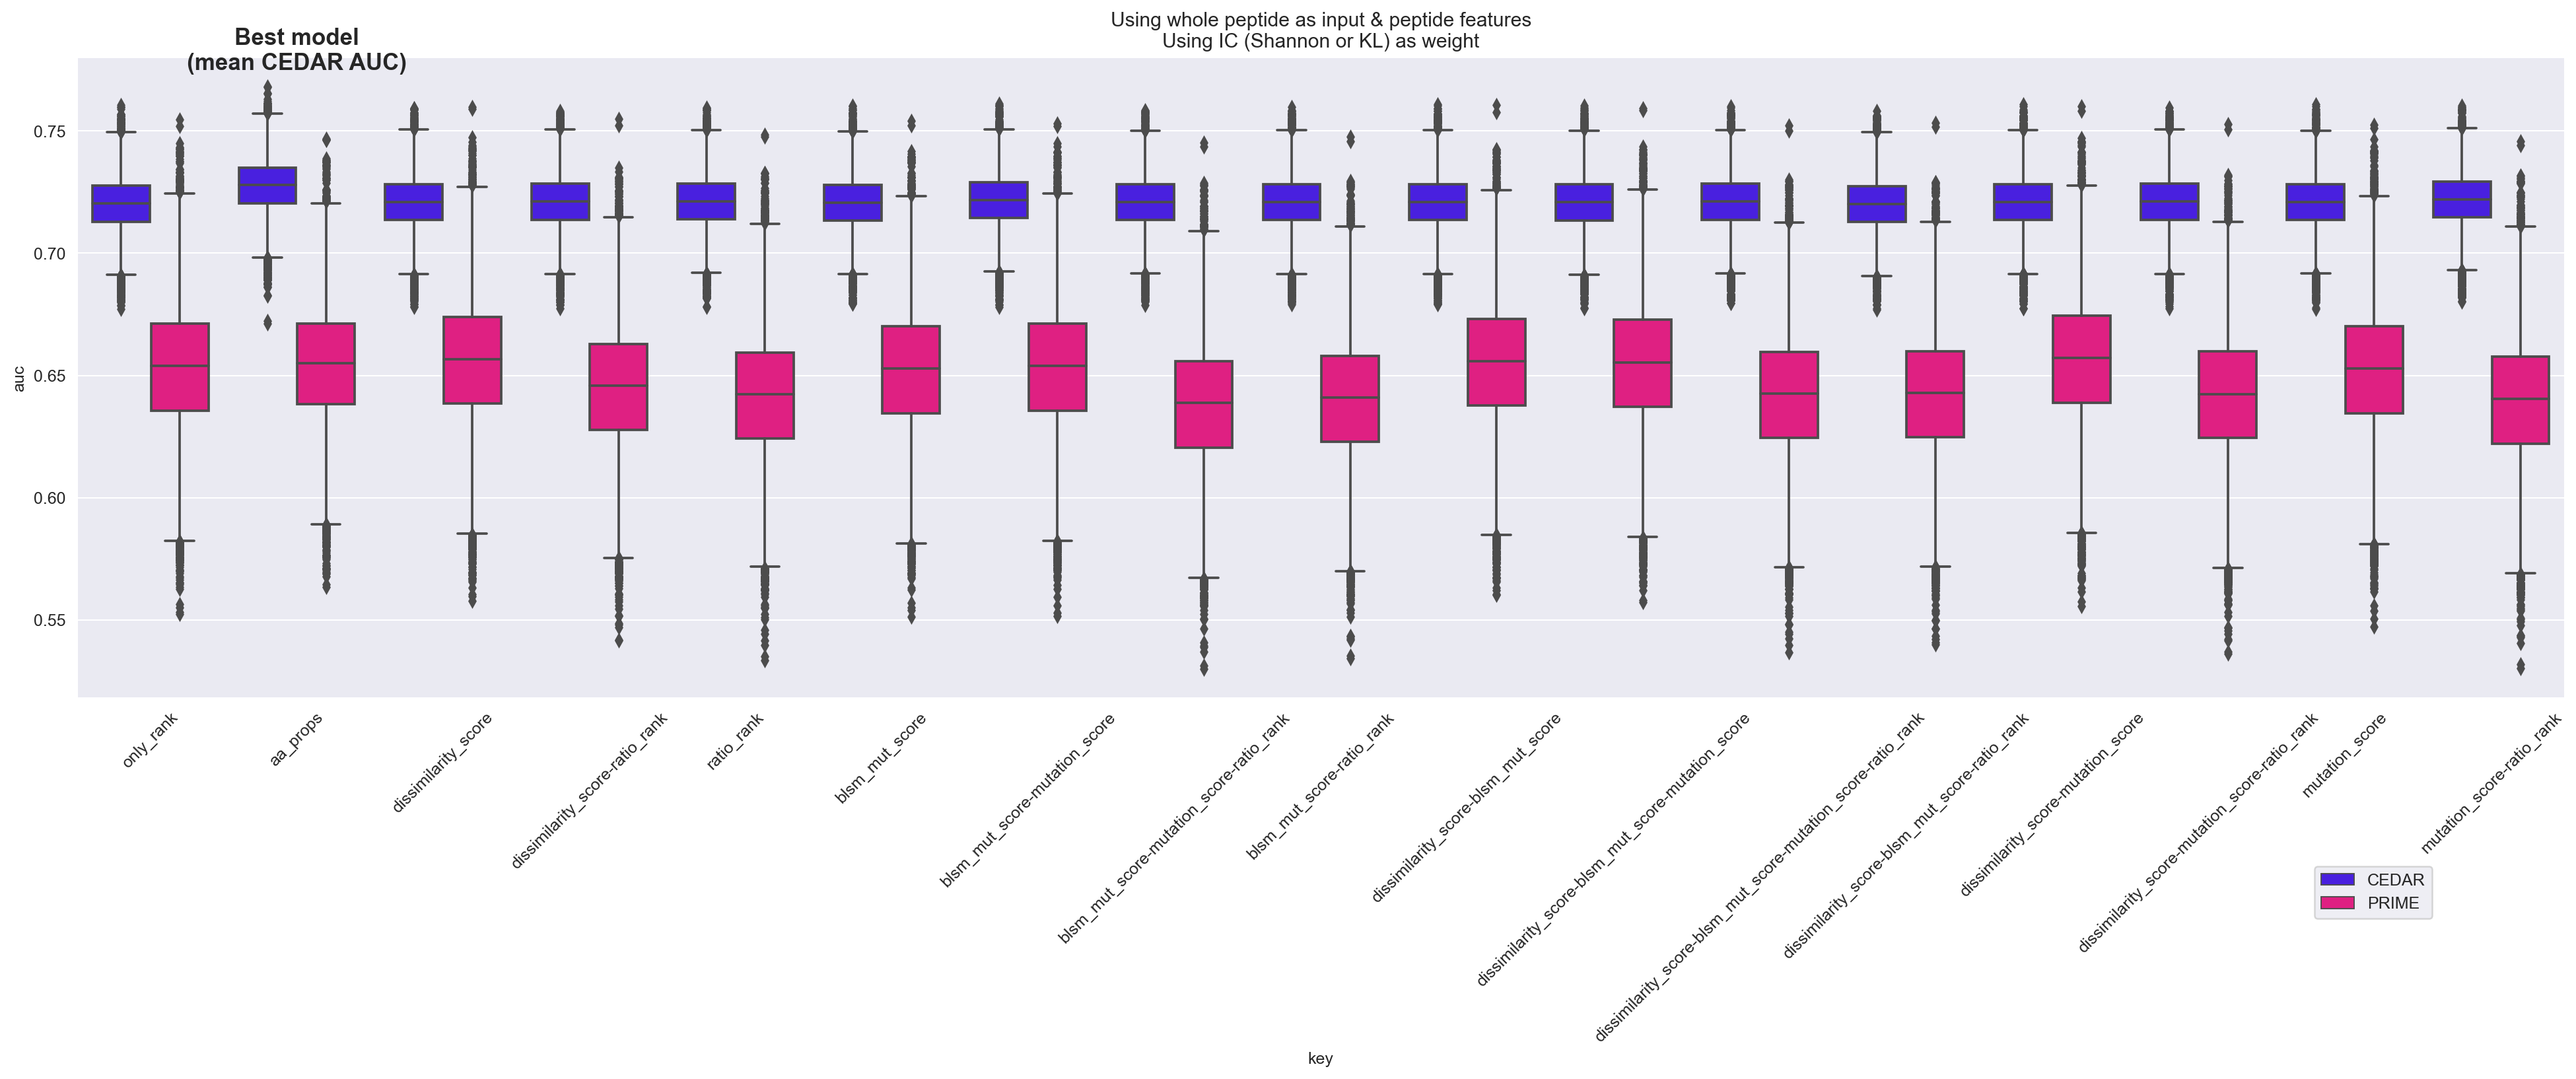

In [519]:
sns.set_palette(HSV)
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=tmp_non, x = 'key', hue = 'evalset', y = 'auc', order=non_core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using whole peptide as input & peptide features\nUsing IC (Shannon or KL) as weight')

max_name = tmp_non.query('evalset=="CEDAR"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = non_core_keys.index(max_name)
a.text(max_idx, 0.775, "Best model\n(mean CEDAR AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})
a.legend(bbox_to_anchor=(0.95, -0.25))

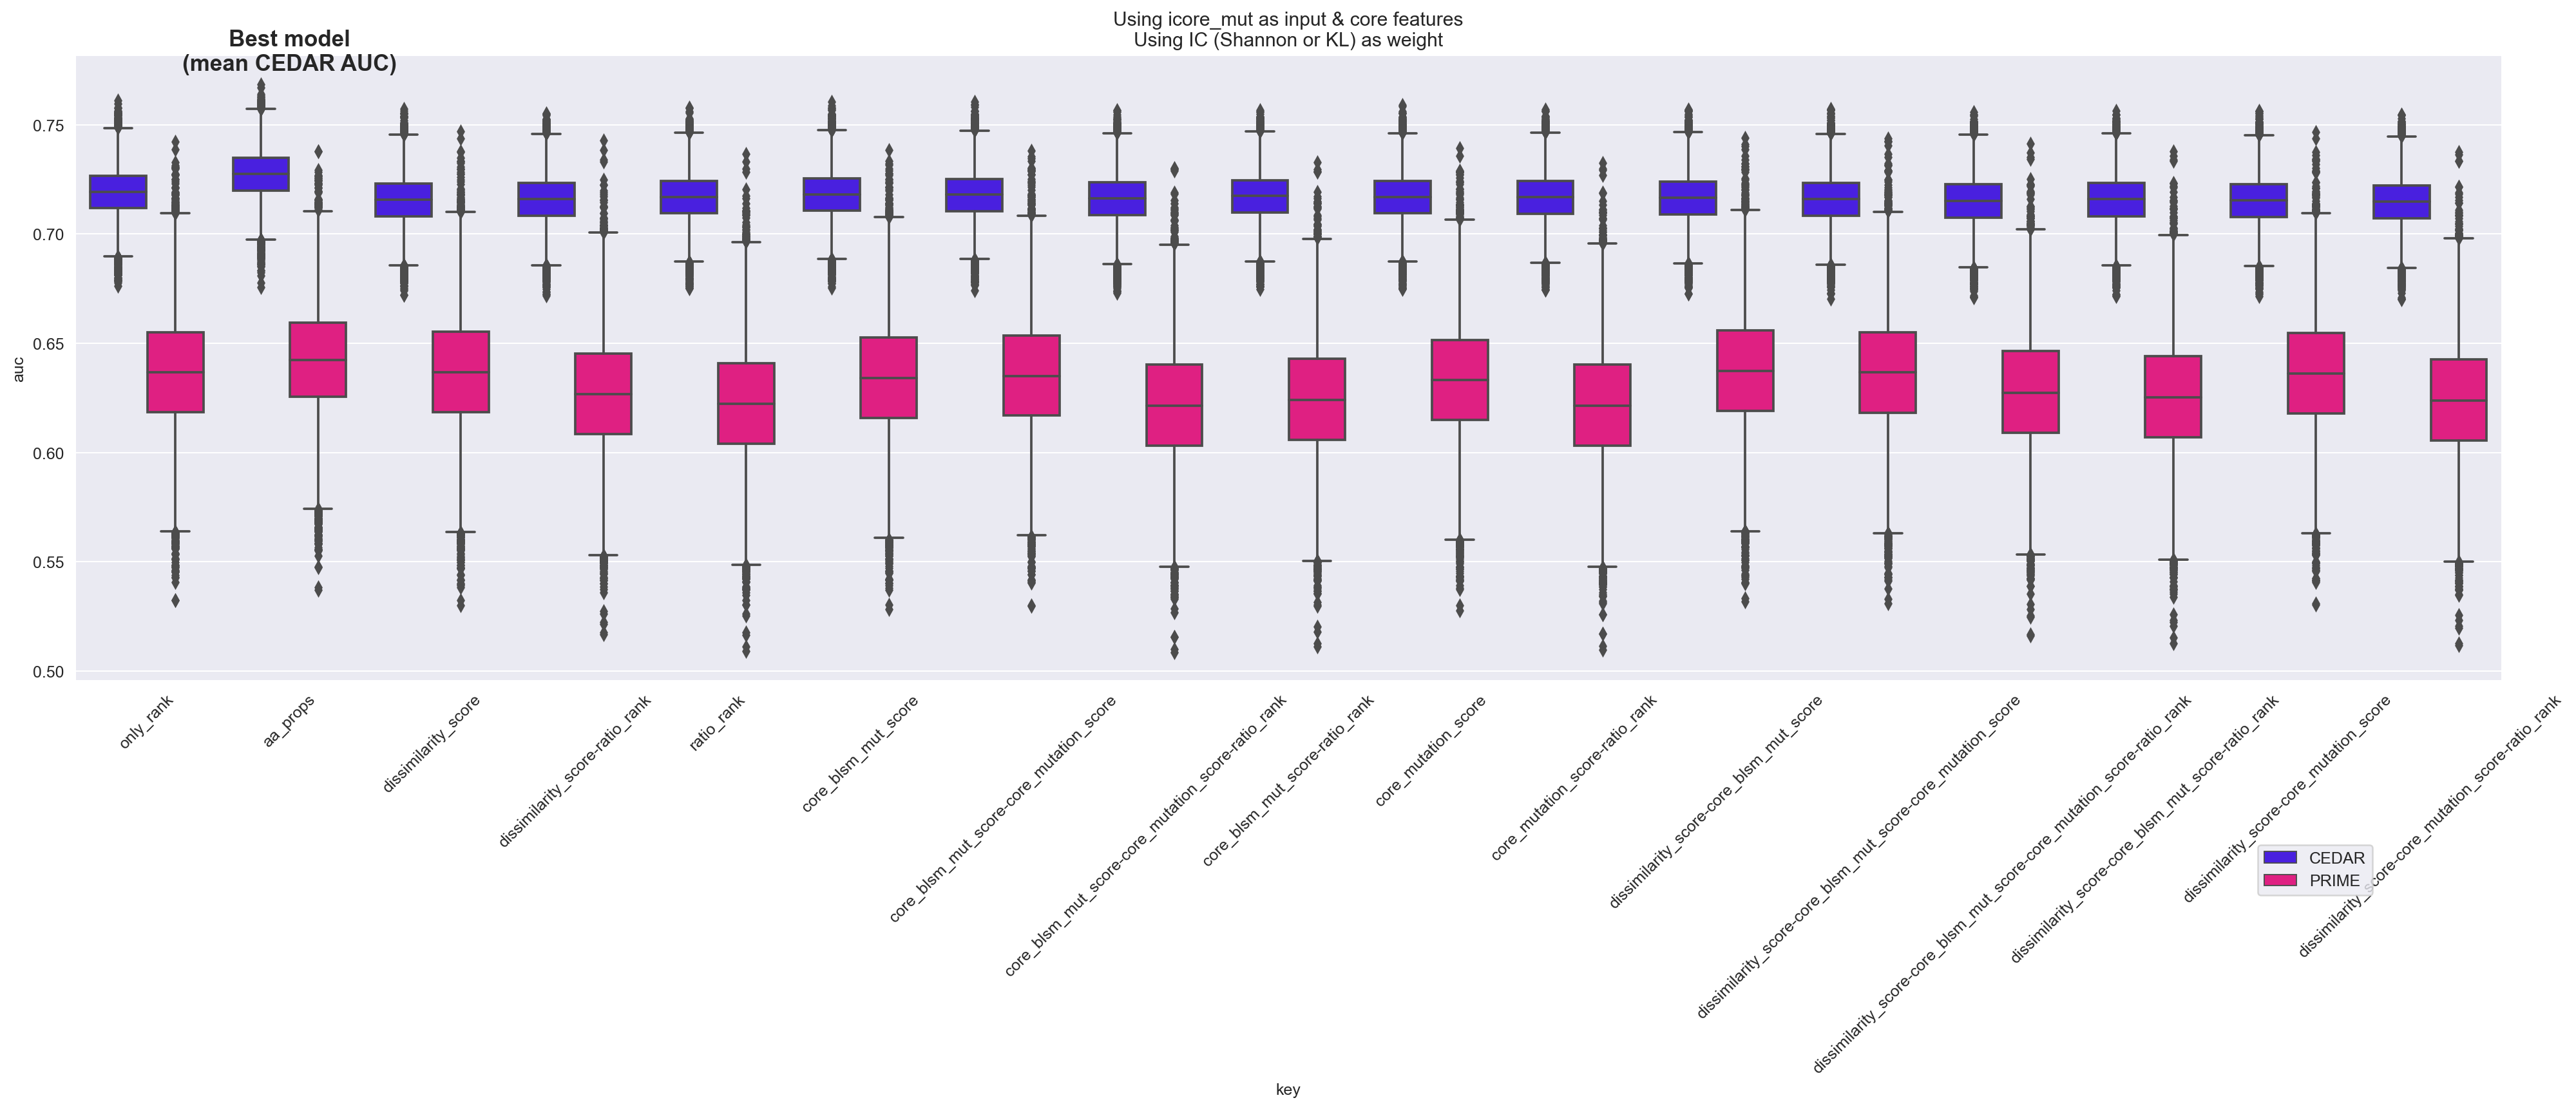

In [518]:
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=tmp_core, x = 'key', hue = 'evalset', y = 'auc', order=core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using icore_mut as input & core features\nUsing IC (Shannon or KL) as weight')

max_name = tmp_core.query('evalset=="CEDAR"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = core_keys.index(max_name)
a.text(max_idx, 0.775, "Best model\n(mean CEDAR AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.25))

In [482]:
prime_tmp_core = df_results.query('(weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="icore_mut" and key in @core_keys')
prime_tmp_non = df_results.query('(weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="Peptide" and key in @non_core_keys')

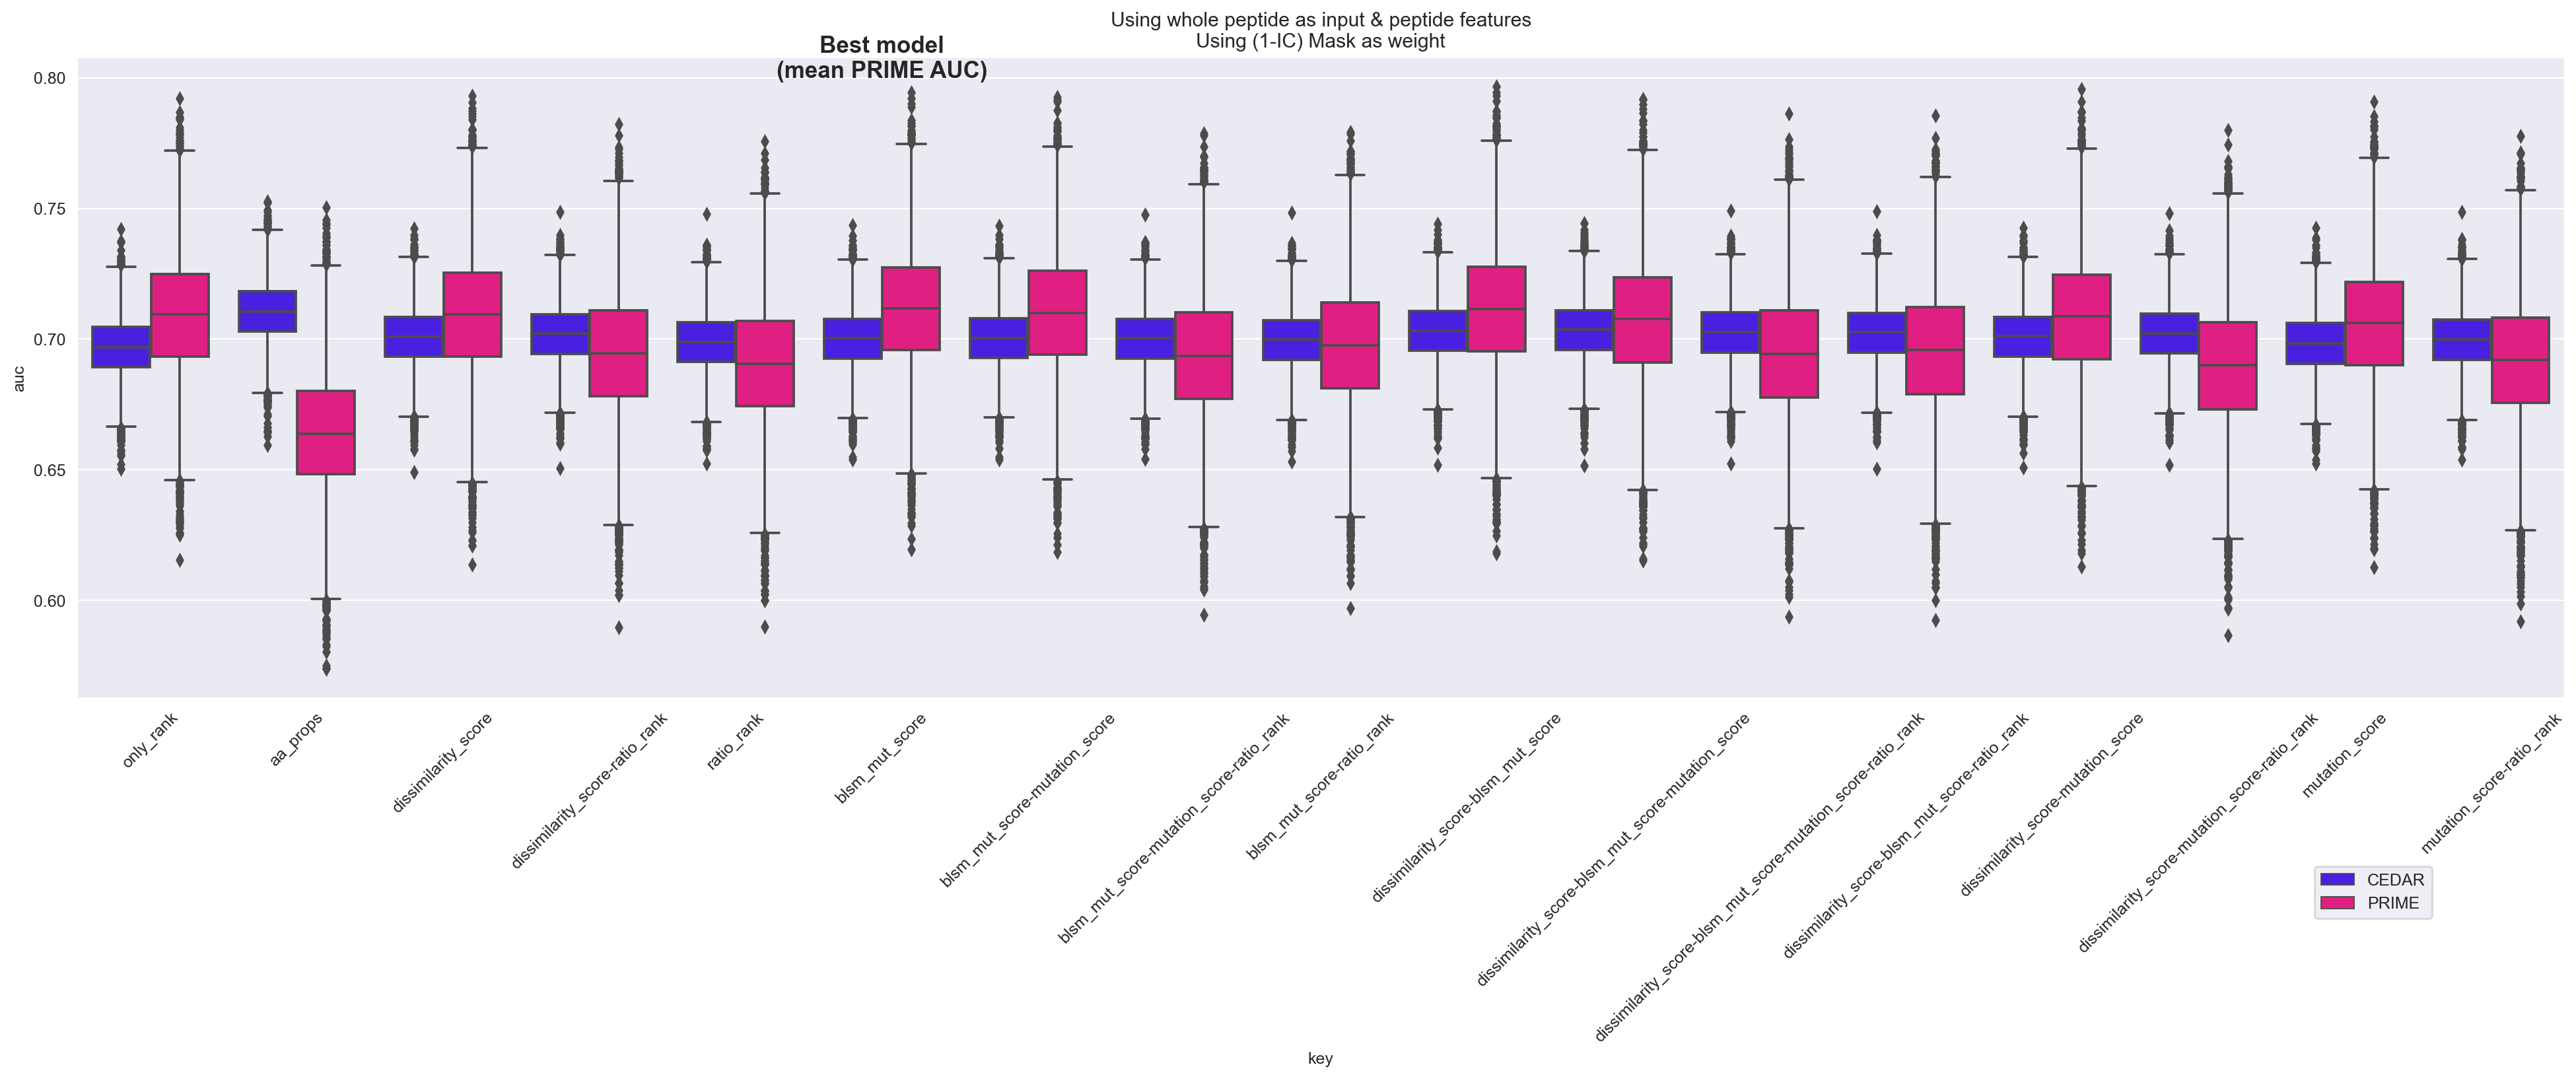

In [517]:
sns.set_palette(HSV)
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=prime_tmp_non, x = 'key', hue = 'evalset', y = 'auc', order=non_core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using whole peptide as input & peptide features\nUsing (1-IC) Mask as weight')

max_name = prime_tmp_non.query('evalset=="PRIME"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = non_core_keys.index(max_name)
a.text(max_idx, 0.8, "Best model\n(mean PRIME AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.25))

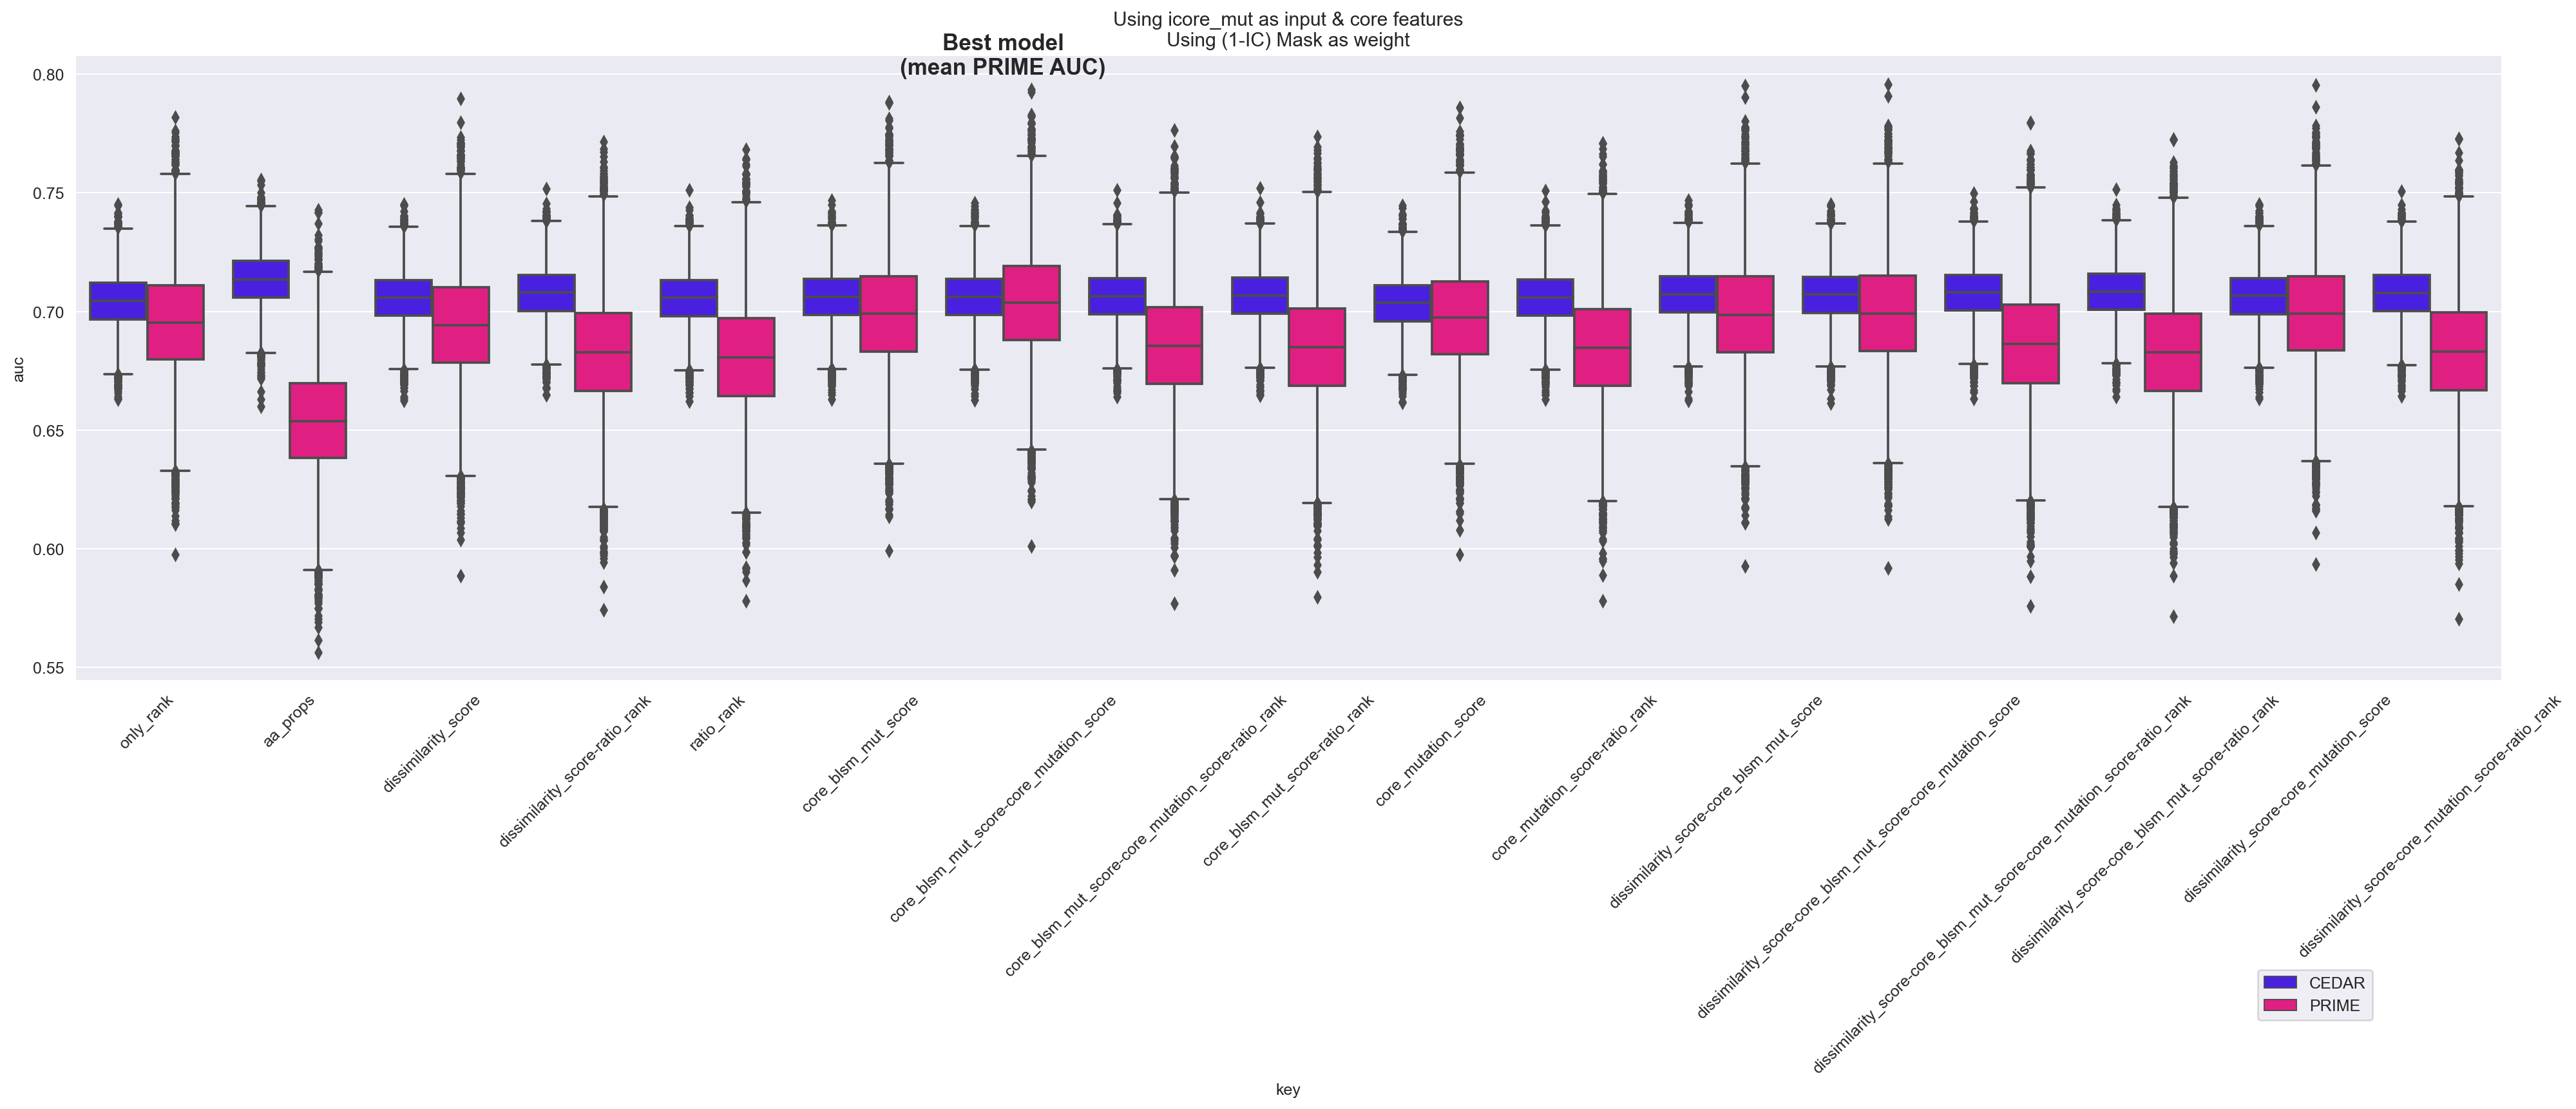

In [522]:
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=prime_tmp_core, x = 'key', hue = 'evalset', y = 'auc', order=core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using icore_mut as input & core features\nUsing (1-IC) Mask as weight')

max_name = prime_tmp_core.query('evalset=="PRIME"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = core_keys.index(max_name)
a.text(max_idx, 0.8, "Best model\n(mean PRIME AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.45))

Text(0.5, 1.0, 'Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing IC (Shannon or KL) as weight')

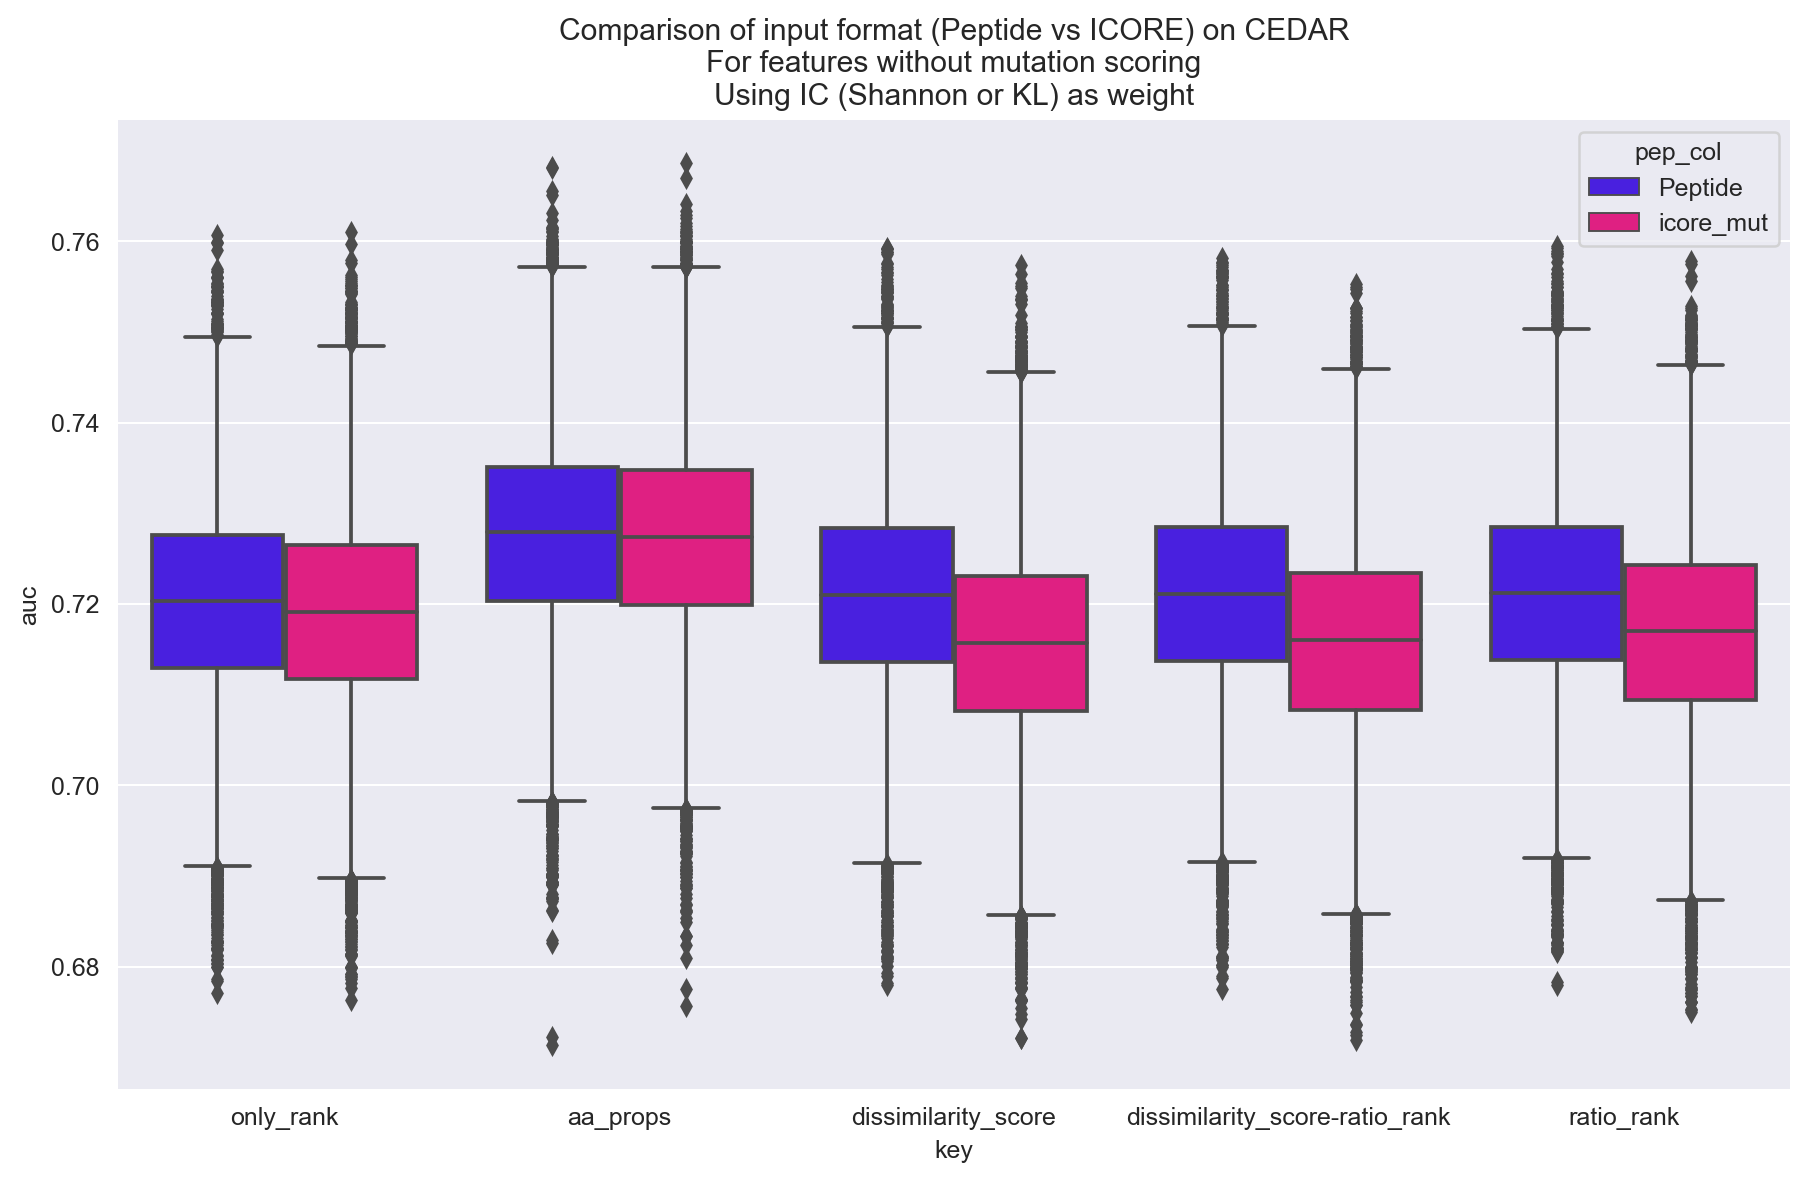

In [696]:
tmp_ = df_results.query('evalset=="CEDAR" and (weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and key in @base_keys')
f,a = plt.subplots(1,1, figsize=(12,7))
sns.boxplot(data=tmp_, x='key', y='auc', hue='pep_col')
plt.setp(a.collections, alpha=0.75)
a.set_title('Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing IC (Shannon or KL) as weight')


Text(0.5, 1.0, 'Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing Mask as weight')

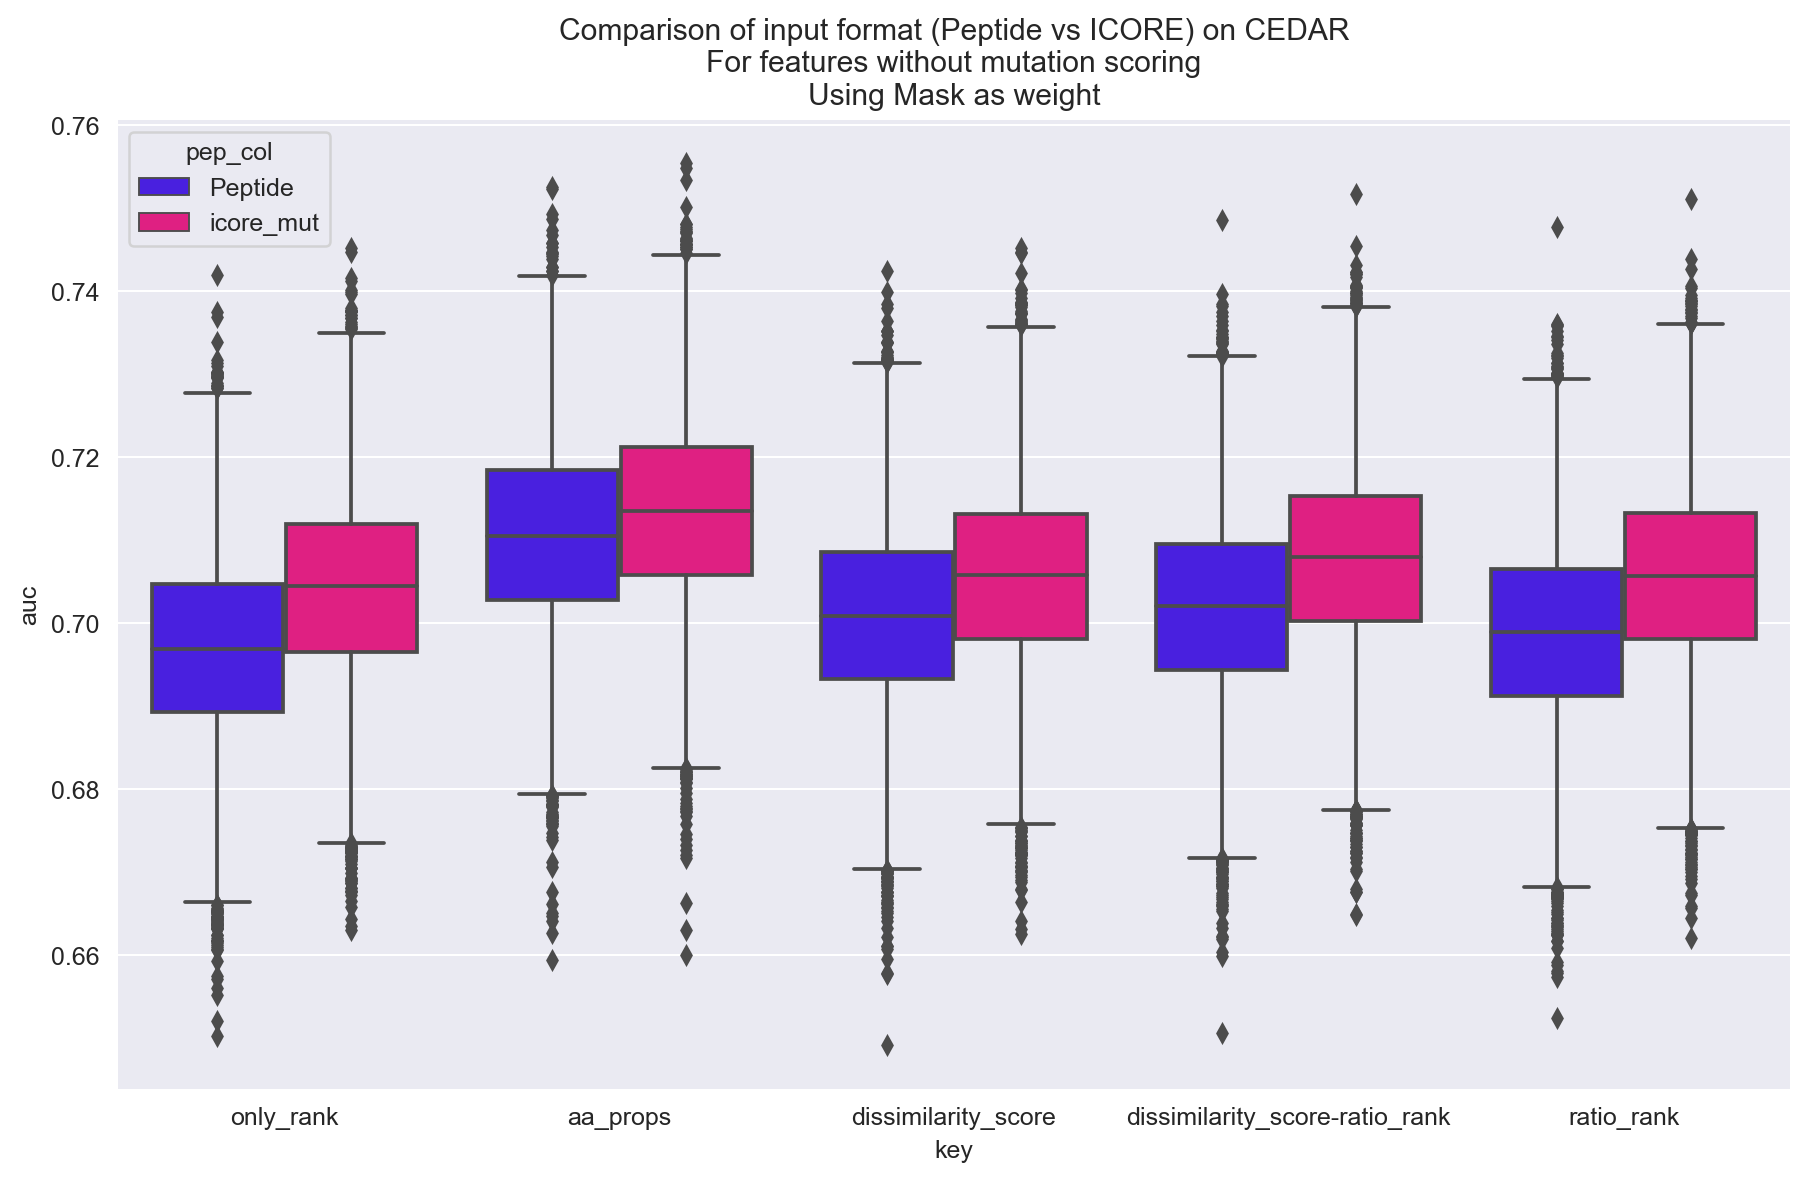

In [697]:
tmp_ = df_results.query('evalset=="CEDAR" and (weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and key in @base_keys')
f,a = plt.subplots(1,1, figsize=(12,7))
sns.boxplot(data=tmp_, x='key', y='auc', hue='pep_col')
plt.setp(a.collections, alpha=0.75)
a.set_title('Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing Mask as weight')


In [61]:
ibel_related_merged['Peptide'].to_csv('../data/mutant/ibel_neoepi_pep.txt', index=False, header=False)

In [64]:
','.join(sorted(ibel_related_merged.HLA.str.replace('HLA-','').unique()))

'A0101,A0201,A0301,A1101,A2501,A3101,B0702,B1801,B5101,B5701,C0501,C0602,C0701,C0702,C1502'

In [65]:
ibel_prime_scores = pd.read_csv('../data/mutant/ibel_neoepi_primescore.txt', sep='\t', comment='#')

In [67]:
ibel_related_merged = ibel_related_merged.merge(ibel_prime_scores.rename('Score_bestAllele':'PRIME_score')['Score_bestAllele'], left_index=True, right_index=True)

In [235]:
ibel_related_merged[['Peptide', 'agg_label']].to_csv('../../ibel_pep_nnalign.pep', index=False, header=False, sep='\t')